# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.

**Important Notes**:
1. Be sure to **document** all of your decisions, as well as your intermediate and final results. Make sure your conclusions and analyses are clearly presented. Don't make us dig into your code or walls of printed results to try to draw conclusions from your code.
2. If you use code from someone else (e.g. Github, Stack Overflow, ChatGPT, etc) you **must be transparent about it**. Document your sources and explain how you adapted any partial solutions to creat **your** solution.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [1]:
import torch

print(torch.__version__)




2.5.1


In [2]:
import copy
from functools import reduce

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset

import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import MNIST, CIFAR10, Imagenette

import wandb
from tqdm import tqdm


#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [7]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

#### Boilerplate training and evaluation code

This is some **very** rough training, evaluation, and plotting code. Again, just to get you started. I will be *very* disappointed if any of this code makes it into your final submission.

In [4]:
# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
        xs = xs.to(device)
        ys = ys.to(device)
        opt.zero_grad()
        logits = model(xs)
        loss = F.cross_entropy(logits, ys)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return np.mean(losses)

# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    predictions = []
    gts = []
    for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
        xs = xs.to(device)
        preds = torch.argmax(model(xs), dim=1)
        gts.append(ys)
        predictions.append(preds.detach().cpu().numpy())
        
    # Return accuracy score and classification report.
    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

In [5]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(nin, nout) for (nin, nout) in zip(layer_sizes[:-1], layer_sizes[1:])])
    
    def forward(self, x):
        return reduce(lambda f, g: lambda x: g(F.relu(f(x))), self.layers, lambda x: x.flatten(1))(x)

print(MLP([784, 100, 10]))

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=10, bias=True)
  )
)


#### A *very* minimal training pipeline.

Here is some basic training and evaluation code to get you started.

**Important**: I cannot stress enough that this is a **terrible** example of how to implement a training pipeline. You can do better!

Training epoch 99: 100%|██████████| 430/430 [00:02<00:00, 159.36it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.962     0.978     0.970       980
           1      0.970     0.986     0.978      1135
           2      0.950     0.938     0.944      1032
           3      0.920     0.942     0.931      1010
           4      0.944     0.954     0.949       982
           5      0.922     0.928     0.925       892
           6      0.953     0.951     0.952       958
           7      0.949     0.938     0.943      1028
           8      0.947     0.905     0.925       974
           9      0.932     0.928     0.930      1009

    accuracy                          0.945     10000
   macro avg      0.945     0.945     0.945     10000
weighted avg      0.945     0.945     0.945     10000



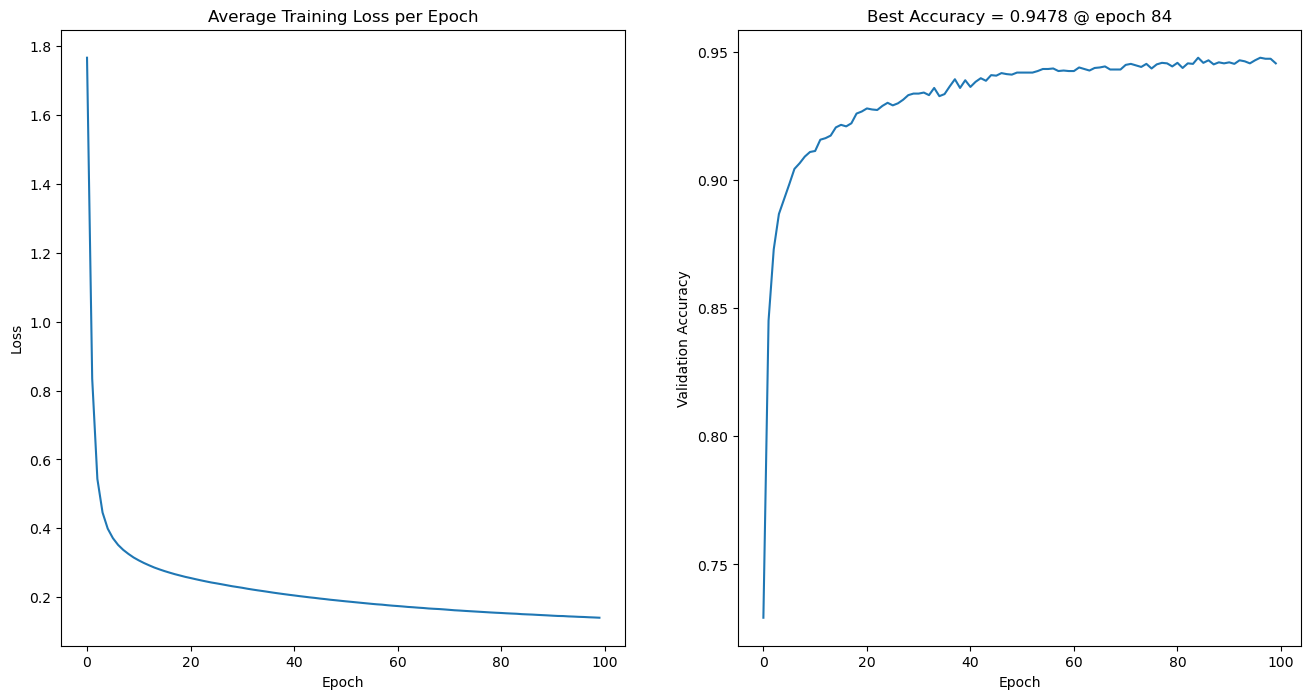

In [6]:
# Training hyperparameters.
device = 'cuda' if torch.cuda.is_available else 'cpu'
epochs = 100
lr = 0.0001
batch_size = 128

# Architecture hyperparameters.
input_size = 28*28
width = 16
depth = 2

# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

# Instantiate model and optimizer.
model_mlp = MLP([input_size] + [width]*depth + [10]).to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

# Training loop.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_mlp, dl_train, opt, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))

# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate_model(model_mlp, dl_test, device=device)[1]}')

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

In [3]:
class my_MLP(nn.Module):
    """A simple MLP with one hidden layer.
     Args:
         input_size (int): Size of the input features.
         hidden_size (int): Number of neurons in the hidden layer.
         num_classes (int): Number of output classes.
     """
    def __init__(self, input_size, hidden_size, num_classes):
        super(my_MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.flatten(1) # MLP requires a 1D input
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    

In [5]:

def train(model, train_loader, val_loader, num_epochs, criterion, optimizer, device, 
          early_stopping_patience=10, early_stopping_min_delta=0.001, scheduler=None):
    """
    Training function wirh Early Stopping
    
    Args:
        model: model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        num_epochs: max number of epochs to train
        criterion: loss function
        optimizer: optimizer
        device: device to use ('cpu' or 'cuda')
        early_stopping_patience: number of epochs with no improvement to wait before stopping
        early_stopping_min_delta: minimum improvement to qualify as an improvement
        scheduler: learning rate scheduler (optional)
    Returns:
        train_losses: list of training losses per epoch
        val_accuracies: list of validation accuracies per epoch
        val_losses: list of validation losses per epoch
    """
    train_losses = []
    val_accuracies = []
    val_losses = []
    
    # Early stopping variables
    best_val_loss = float('inf')
    best_val_acc = 0.0
    patience_counter = 0
    best_model_state = None
    early_stopped = False
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        val_acc, val_loss, _ = evaluate(model, val_loader, device, criterion)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)
        
        # Learning rate scheduling
        current_lr = optimizer.param_groups[0]['lr']
        if scheduler is not None:
            if hasattr(scheduler, 'step'):
                # use val_loss for ReduceLROnPlateau, no argument for other schedulers
                if 'ReduceLR' in scheduler.__class__.__name__:
                    scheduler.step(val_loss)
                else:
                    scheduler.step()
        
        # Early stopping check
        improved = False
        
        # Uses validation loss as main metric for early stopping
        if val_loss < (best_val_loss - early_stopping_min_delta):
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            improved = True
        else:
            patience_counter += 1
        
        if wandb.run is not None:
            wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "learning_rate": current_lr,
            "patience_counter": patience_counter,
            "best_val_loss": best_val_loss,
            "best_val_acc": best_val_acc
            })
        
        
        status = "NEW BEST" if improved else f"({patience_counter}/{early_stopping_patience})"
        print(f'Epoch {epoch+1:3d}: Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% {status}')
        
        # Early stopping check
        if patience_counter >= early_stopping_patience:
            print(f"\n Early stopping triggered after {epoch+1} epochs")
            print(f"Best validation loss: {best_val_loss:.4f} (accuracy: {best_val_acc:.2f}%)")
            early_stopped = True
            break
    
    # Restore best model weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\n Restored best model weights (val_loss: {best_val_loss:.4f})")
    
    return  train_losses, val_accuracies, val_losses
    
    
def evaluate(model, data_loader, device, criterion=None, log_wandb=False):
    """
    Evaluate the model on the given data loader.
    If criterion is provided, compute and return the average loss as well.
    Args:
        model: model to evaluate
        data_loader: DataLoader for evaluation data
        device: device to use ('cpu' or 'cuda')
        criterion: loss function (optional)
        log_wandb: whether to log results to wandb (default: False)
    Returns:
        accuracy: accuracy on the dataset
        avg_loss: average loss (if criterion is provided, else None)
        report: classification report as a string"""
    model.eval()
    predictions = []
    gts = []
    class_names = [str(i) for i in range(10)]
    total_loss = 0.0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            if criterion is not None:
                loss = criterion(output, target)
                total_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            predictions.extend(predicted.cpu().numpy())
            gts.extend(target.cpu().numpy())
    accuracy = accuracy_score(gts, predictions)*100
    # if used on validation set
    if criterion is not None:
        avg_loss = total_loss / len(data_loader)
        wandb.log({
            "val_loss": avg_loss,
            "val_accuracy": accuracy
        })
    # if used on test set 
    else:
        avg_loss = None
        wandb.log({
            "test_accuracy": accuracy
        })

    report = classification_report(gts, predictions, zero_division=0, digits=3)
    table = wandb.Table(columns=["classification_report"])
    table.add_data(report)
    wandb.log({"classification_report": table})
    wandb.log({
        "confusion_matrix": wandb.plot.confusion_matrix(
            preds=predictions,
            y_true=gts,
            class_names=class_names
        )
    })
    return accuracy, avg_loss, report

def plot_training_metrics(train_losses, val_accuracies, val_losses=None, save_path=None, model_name=None, model_depth=None):
    epochs = range(1, len(train_losses) + 1)
    """
    Plots training loss, validation accuracy, and optionally validation loss over epochs.
    Args:
        train_losses: list of training losses per epoch
        val_accuracies: list of validation accuracies per epoch
        val_losses: list of validation losses per epoch (optional)
        save_path: path to save the plot (optional)
        model_name: name of the model (optional, for plot titles)
        model_depth: depth of the model (optional, for plot titles)
    """
    
    # create subplots
    if val_losses is not None:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    else:

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot with model name if provided
    if model_name is not None:
        # Plot 1: Training Loss
        ax1.plot(epochs, train_losses, 'b-', label=f'Training Loss ({model_name}, Depth ({model_depth}))', linewidth=2)
        ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.grid(True, alpha=0.3)
        ax1.legend()

        # Plot 2: Validation Accuracy
        ax2.plot(epochs, val_accuracies, 'g-', label=f'Validation Accuracy ({model_name}, Depth ({model_depth}))', linewidth=2)
        ax2.set_title('Validation Accuracy', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.grid(True, alpha=0.3)
        ax2.legend()

        # Plot 3: Validation Loss (if provided)
        if val_losses is not None:
            ax3.plot(epochs, val_losses, 'r-', label=f'Validation Loss ({model_name}, Depth ({model_depth}))', linewidth=2)
            ax3.set_title('Validation Loss', fontsize=14, fontweight='bold')
            ax3.set_xlabel('Epoch')
            ax3.set_ylabel('Loss')
            ax3.grid(True, alpha=0.3)
            ax3.legend()

    else:
        ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
        ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.grid(True, alpha=0.3)
        ax1.legend()

        # Plot 2: Validation Accuracy
        ax2.plot(epochs, val_accuracies, 'g-', label='Validation Accuracy', linewidth=2)
        ax2.set_title('Validation Accuracy', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.grid(True, alpha=0.3)
        ax2.legend()

            # Plot 3: Validation Loss (if provided)
        if val_losses is not None:
            ax3.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
            ax3.set_title('Validation Loss', fontsize=14, fontweight='bold')
            ax3.set_xlabel('Epoch')
            ax3.set_ylabel('Loss')
            ax3.grid(True, alpha=0.3)
            ax3.legend()

    plt.tight_layout()
    
    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot salvato in: {save_path}")
    
    plt.show()



In [8]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
batch_size = 128
epochs = 100
input_size = 28*28
num_classes = 10
# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

criterion = nn.CrossEntropyLoss()

wandb: Currently logged in as: elena-daveri00 (elena-daveri00-universit-di-firenze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch   1: Train Loss: 1.4038, Val Loss: 0.8194, Val Acc: 80.76% NEW BEST
Epoch   2: Train Loss: 0.6473, Val Loss: 0.5134, Val Acc: 86.82% NEW BEST
Epoch   3: Train Loss: 0.4646, Val Loss: 0.4054, Val Acc: 88.80% NEW BEST
Epoch   4: Train Loss: 0.3887, Val Loss: 0.3515, Val Acc: 90.14% NEW BEST
Epoch   5: Train Loss: 0.3461, Val Loss: 0.3186, Val Acc: 90.84% NEW BEST
Epoch   6: Train Loss: 0.3184, Val Loss: 0.2964, Val Acc: 91.58% NEW BEST
Epoch   7: Train Loss: 0.2989, Val Loss: 0.2825, Val Acc: 91.76% NEW BEST
Epoch   8: Train Loss: 0.2844, Val Loss: 0.2695, Val Acc: 92.02% NEW BEST
Epoch   9: Train Loss: 0.2729, Val Loss: 0.2597, Val Acc: 92.34% NEW BEST
Epoch  10: Train Loss: 0.2636, Val Loss: 0.2518, Val Acc: 92.44% NEW BEST
Epoch  11: Train Loss: 0.2553, Val Loss: 0.2478, Val Acc: 92.52% NEW BEST
Epoch  12: Train Loss: 0.2487, Val Loss: 0.2392, Val Acc: 92.84% NEW BEST
Epoch  13: Train Loss: 0.2428, Val Loss: 0.2344, Val Acc: 93.00% NEW BEST
Epoch  14: Train Loss: 0.2372, Val Los

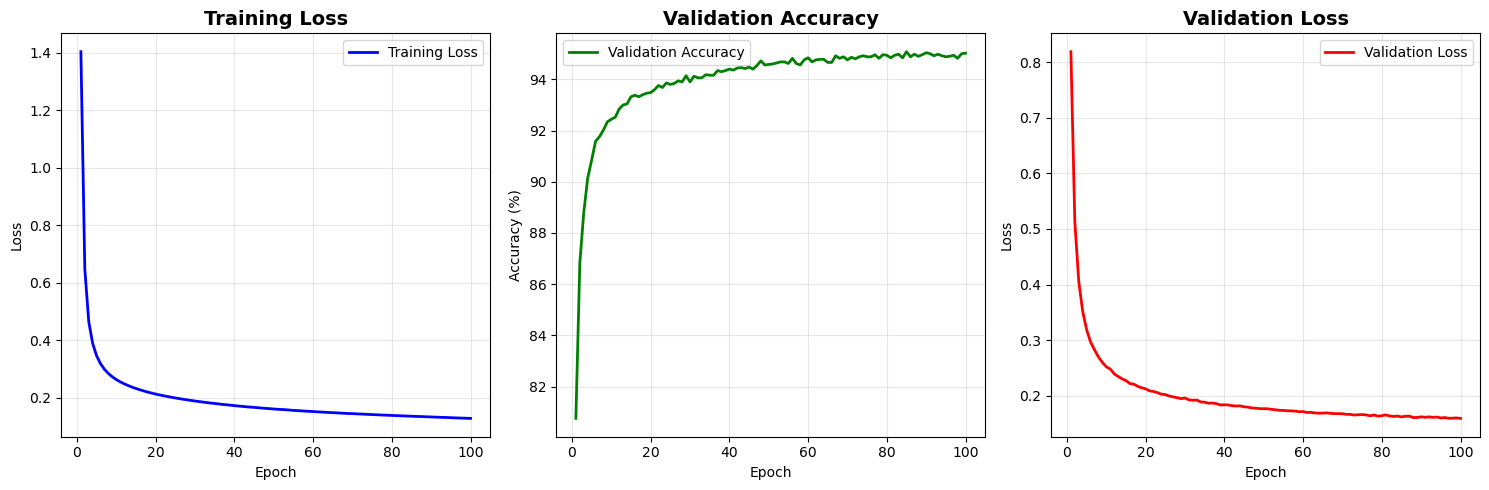

Test Accuracy: 95.09%

Classification Report:
              precision    recall  f1-score   support

           0      0.960     0.982     0.971       980
           1      0.977     0.986     0.982      1135
           2      0.956     0.945     0.950      1032
           3      0.925     0.952     0.939      1010
           4      0.949     0.955     0.952       982
           5      0.945     0.927     0.936       892
           6      0.952     0.960     0.956       958
           7      0.958     0.944     0.951      1028
           8      0.943     0.927     0.935       974
           9      0.939     0.925     0.932      1009

    accuracy                          0.951     10000
   macro avg      0.950     0.950     0.950     10000
weighted avg      0.951     0.951     0.951     10000



In [10]:
# Training hyperparameters and training of an MLP with 1 hidden layer of 16 units
lr = 0.0001

hidden_size = 16

model_my_MLP = my_MLP(input_size, hidden_size, num_classes).to(device)
optimizer = torch.optim.Adam(model_my_MLP.parameters(), lr=lr)

run = wandb.init(
    project="DLALabs",
    name="lab1_esercizio1",
    config={
        "epochs": 100,
        "learning_rate": 0.0001,
        "batch_size": 128,
        "input_size": 28*28,
        "hidden_size": 16,
        "num_classes": 10,
        "optimizer": "Adam",
        "loss_function": "CrossEntropyLoss"
    }
)
run.watch(model_my_MLP, log="gradients", log_freq=50) # Log gradients
train_losses, val_accuracies, val_losses = train(model_my_MLP, dl_train, dl_val, epochs, criterion, optimizer, device)

plot_training_metrics(train_losses=train_losses,val_accuracies=val_accuracies, val_losses=val_losses)
(accuracy, _, report) = evaluate(model_my_MLP, dl_test, device, log_wandb=True)

print(f'Test Accuracy: {accuracy:.2f}%')
print(f'\nClassification Report:\n{report}')

### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case. 

In [7]:
# MLP with configurable number of hidden layers and sizes
class My_Configurable_MLP(nn.Module):
    def __init__(self, input_size, hidden_layers_sizes, num_classes, dropout_rate=0.1):
        """
        Configurable MLP with multiple hidden layers, ReLU activations, and Dropout.
        Args:
            input_size: size of the input layer
            hidden_layers_sizes: list of sizes for each hidden layer or a single integer for uniform layers"""
        super(My_Configurable_MLP, self).__init__()
        layers = []
        layer_input_size = input_size
        
        for i, layer_size in enumerate(hidden_layers_sizes):
            layers.append(nn.Linear(layer_input_size, layer_size))
            layers.append(nn.BatchNorm1d(layer_size))  
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            layer_input_size = layer_size
        
        layers.append(nn.Linear(layer_input_size, num_classes))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.flatten(1)
        return self.network(x)

class Residual_MLP(nn.Module):
    def __init__(self, input_size, hidden_layers_sizes, num_classes):
        """
        MLP with residual connections between hidden layers
        Args:
            input_size: size of the input layer
            hidden_layers_sizes: list of sizes for each hidden layer or a single integer for uniform layers
            num_classes: number of output classes
        """
        super(Residual_MLP, self).__init__()
        
        if isinstance(hidden_layers_sizes, int):
            hidden_layers_sizes = [hidden_layers_sizes] * 2
            
        # Input layer
        self.fc_input = nn.Linear(input_size, hidden_layers_sizes[0])
        self.input_bn = nn.BatchNorm1d(hidden_layers_sizes[0])  # BatchNorm after input layer
        
        # Hidden layers with residual connections
        self.hidden_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.projections = nn.ModuleList()
        
        for i in range(len(hidden_layers_sizes) - 1):
            input_dim = hidden_layers_sizes[i]
            output_dim = hidden_layers_sizes[i + 1]
            
            # primary layer
            self.hidden_layers.append(nn.Linear(input_dim, output_dim))
            self.batch_norms.append(nn.BatchNorm1d(output_dim))
            
            # Projection layer for residual connection if dimensions differ
            if input_dim != output_dim:
                self.projections.append(nn.Linear(input_dim, output_dim))
            else:
                self.projections.append(nn.Identity())
        
        # Output layer
        self.fc_output = nn.Linear(hidden_layers_sizes[-1], num_classes)

    def forward(self, x):
        # Flatten input
        x = x.flatten(1)
        
        # Input layer
        x = self.fc_input(x)
        x = self.input_bn(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)  
        
        # Hidden layers with residual connections
        for i, (layer, bn, projection) in enumerate(zip(self.hidden_layers, self.batch_norms, self.projections)):
            # Save input for residual connection
            residual = x
            
            # Forward pass
            x = layer(x)
            x = bn(x)
            x = F.relu(x)
            x = F.dropout(x, p=0.1, training=self.training)
            
            # Residual connection
            residual = projection(residual)  # Adapt residual if dimensions differ
            x = x + residual
        
        # Output layer (no activation for CrossEntropyLoss)
        x = self.fc_output(x)
        return x

In [9]:
# Training hyperparameters and training of an MLP with varying depth
device = 'cuda' if torch.cuda.is_available else 'cpu'
batch_size = 128
epochs = 100
input_size = 28*28
num_classes = 10
# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)
width = 16
lr = 0.001
criterion = nn.CrossEntropyLoss()
depth_values = [1, 3, 5, 8, 16, 24, 32, 50]

Epoch   1: Train Loss: 0.8930, Val Loss: 0.4289, Val Acc: 89.78% NEW BEST
Epoch   2: Train Loss: 0.4384, Val Loss: 0.3110, Val Acc: 91.64% NEW BEST
Epoch   3: Train Loss: 0.3696, Val Loss: 0.2624, Val Acc: 92.34% NEW BEST
Epoch   4: Train Loss: 0.3418, Val Loss: 0.2392, Val Acc: 93.06% NEW BEST
Epoch   5: Train Loss: 0.3170, Val Loss: 0.2190, Val Acc: 93.44% NEW BEST
Epoch   6: Train Loss: 0.3009, Val Loss: 0.2189, Val Acc: 93.48% (1/10)
Epoch   7: Train Loss: 0.2936, Val Loss: 0.2090, Val Acc: 93.58% NEW BEST
Epoch   8: Train Loss: 0.2817, Val Loss: 0.1952, Val Acc: 94.32% NEW BEST
Epoch   9: Train Loss: 0.2696, Val Loss: 0.1945, Val Acc: 94.16% (1/10)
Epoch  10: Train Loss: 0.2640, Val Loss: 0.1884, Val Acc: 94.14% NEW BEST
Epoch  11: Train Loss: 0.2581, Val Loss: 0.1858, Val Acc: 94.42% NEW BEST
Epoch  12: Train Loss: 0.2493, Val Loss: 0.1790, Val Acc: 94.60% NEW BEST
Epoch  13: Train Loss: 0.2471, Val Loss: 0.1793, Val Acc: 94.72% (1/10)
Epoch  14: Train Loss: 0.2411, Val Loss: 0.1

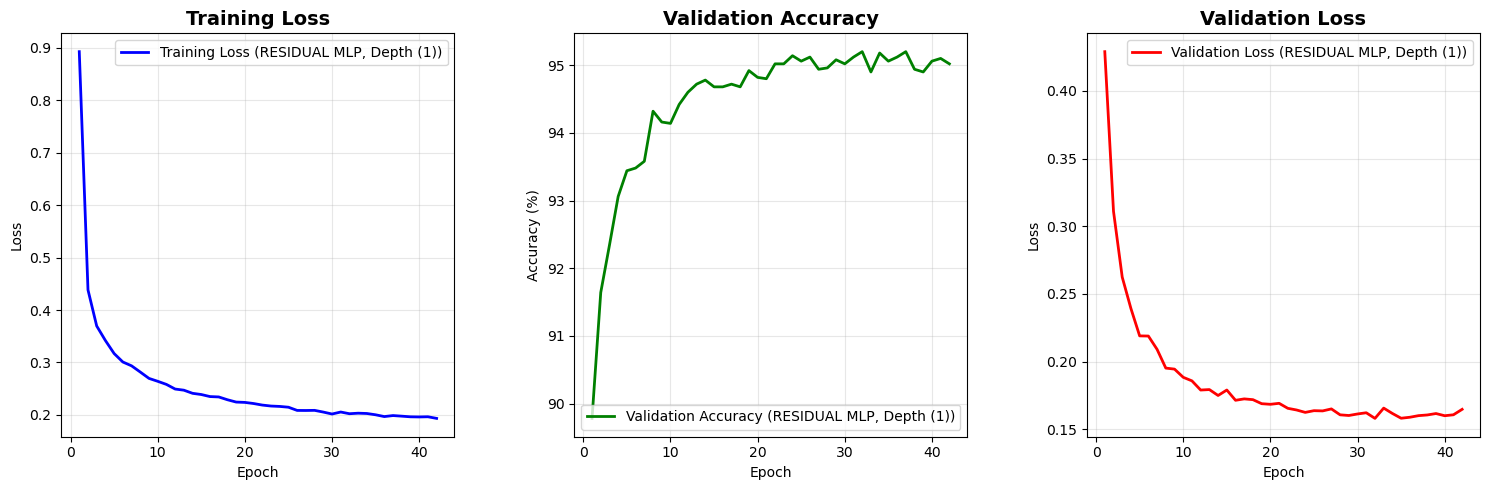

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 95.16%

Classification Report:
              precision    recall  f1-score   support

           0      0.962     0.986     0.974       980
           1      0.968     0.979     0.973      1135
           2      0.944     0.939     0.942      1032
           3      0.957     0.950     0.953      1010
           4      0.942     0.955     0.948       982
           5      0.935     0.936     0.936       892
           6      0.956     0.974     0.965       958
           7      0.962     0.937     0.949      1028
           8      0.933     0.936     0.934       974
           9      0.953     0.922     0.937      1009

    accuracy                          0.952     10000
   macro avg      0.951     0.951     0.951     10000
weighted avg      0.952     0.952     0.952     10000



best_val_acc,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████████████
best_val_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▂▁▁▂▁▁▁▂▁▂▁▂▂▁▂▁▁▁▂▂▃▁▂▂▃▁▂▂▃▄▅▅▆▇█
test_accuracy,▁
train_loss,█▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▃▄▅▆▆▇▇▇▇▇▇▇█████████████████████████
val_loss,█▅▅▄▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_acc,95.2
best_val_loss,0.15806


Epoch   1: Train Loss: 0.7759, Val Loss: 0.3113, Val Acc: 91.40% NEW BEST
Epoch   2: Train Loss: 0.3972, Val Loss: 0.2417, Val Acc: 92.74% NEW BEST
Epoch   3: Train Loss: 0.3520, Val Loss: 0.2160, Val Acc: 93.82% NEW BEST
Epoch   4: Train Loss: 0.3216, Val Loss: 0.2030, Val Acc: 93.82% NEW BEST
Epoch   5: Train Loss: 0.3025, Val Loss: 0.1916, Val Acc: 94.10% NEW BEST
Epoch   6: Train Loss: 0.2898, Val Loss: 0.1857, Val Acc: 93.96% NEW BEST
Epoch   7: Train Loss: 0.2728, Val Loss: 0.1741, Val Acc: 94.42% NEW BEST
Epoch   8: Train Loss: 0.2693, Val Loss: 0.1745, Val Acc: 94.58% (1/10)
Epoch   9: Train Loss: 0.2582, Val Loss: 0.1656, Val Acc: 94.80% NEW BEST
Epoch  10: Train Loss: 0.2553, Val Loss: 0.1645, Val Acc: 95.00% NEW BEST
Epoch  11: Train Loss: 0.2522, Val Loss: 0.1641, Val Acc: 94.76% (1/10)
Epoch  12: Train Loss: 0.2453, Val Loss: 0.1641, Val Acc: 94.58% (2/10)
Epoch  13: Train Loss: 0.2431, Val Loss: 0.1614, Val Acc: 94.98% NEW BEST
Epoch  14: Train Loss: 0.2333, Val Loss: 0.1

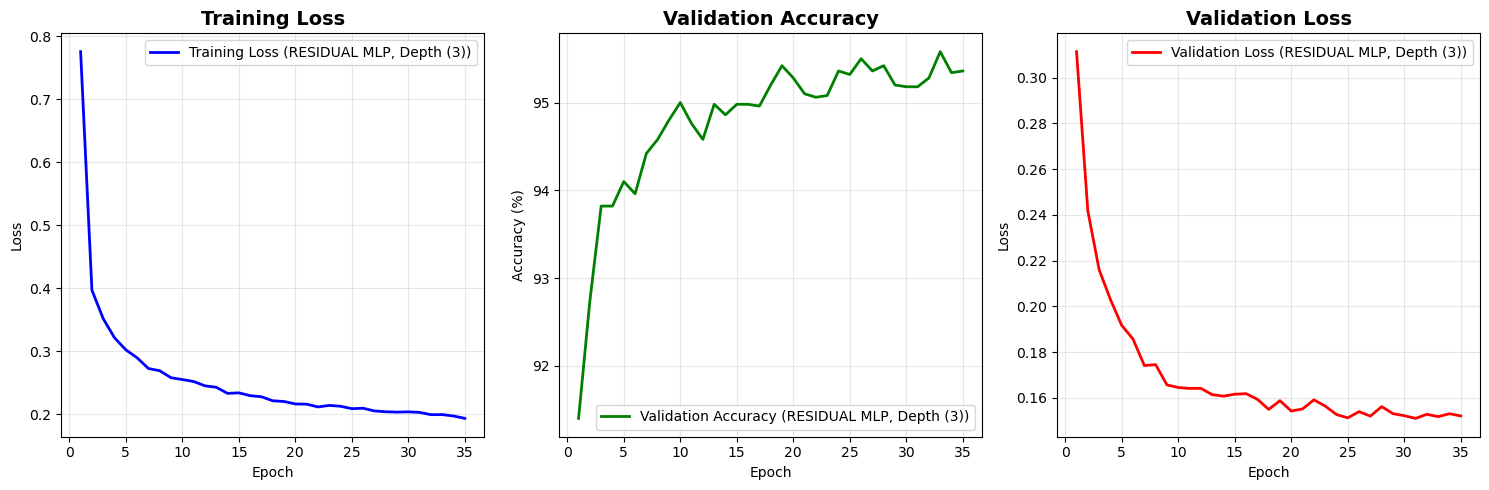

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 95.69%

Classification Report:
              precision    recall  f1-score   support

           0      0.964     0.983     0.973       980
           1      0.976     0.982     0.979      1135
           2      0.964     0.952     0.958      1032
           3      0.930     0.951     0.941      1010
           4      0.955     0.958     0.957       982
           5      0.964     0.927     0.945       892
           6      0.963     0.972     0.967       958
           7      0.954     0.954     0.954      1028
           8      0.944     0.948     0.946       974
           9      0.955     0.937     0.945      1009

    accuracy                          0.957     10000
   macro avg      0.957     0.956     0.957     10000
weighted avg      0.957     0.957     0.957     10000



best_val_acc,▁▃▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██████████████████
best_val_loss,█▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▁▁▂▁▁▂▂▁▂▂▃▁▁▂▂▃▄▅▁▁▂▂▃▄▅▅▆▇▇█
test_accuracy,▁
train_loss,█▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▅▅▆▅▆▆▆▇▇▇▇▇▇▇▇▇█▇▇▇▇▇███████▇▇▇▇████
val_loss,██▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_acc,95.32
best_val_loss,0.15122


Epoch   1: Train Loss: 0.7465, Val Loss: 0.2875, Val Acc: 91.34% NEW BEST
Epoch   2: Train Loss: 0.3967, Val Loss: 0.2252, Val Acc: 93.28% NEW BEST
Epoch   3: Train Loss: 0.3428, Val Loss: 0.2077, Val Acc: 93.68% NEW BEST
Epoch   4: Train Loss: 0.3172, Val Loss: 0.1929, Val Acc: 94.16% NEW BEST
Epoch   5: Train Loss: 0.2977, Val Loss: 0.1800, Val Acc: 94.80% NEW BEST
Epoch   6: Train Loss: 0.2839, Val Loss: 0.1774, Val Acc: 94.82% NEW BEST
Epoch   7: Train Loss: 0.2759, Val Loss: 0.1750, Val Acc: 94.62% NEW BEST
Epoch   8: Train Loss: 0.2697, Val Loss: 0.1709, Val Acc: 94.60% NEW BEST
Epoch   9: Train Loss: 0.2624, Val Loss: 0.1630, Val Acc: 94.82% NEW BEST
Epoch  10: Train Loss: 0.2513, Val Loss: 0.1626, Val Acc: 94.80% (1/10)
Epoch  11: Train Loss: 0.2482, Val Loss: 0.1594, Val Acc: 95.10% NEW BEST
Epoch  12: Train Loss: 0.2428, Val Loss: 0.1577, Val Acc: 95.06% NEW BEST
Epoch  13: Train Loss: 0.2363, Val Loss: 0.1524, Val Acc: 95.16% NEW BEST
Epoch  14: Train Loss: 0.2363, Val Loss:

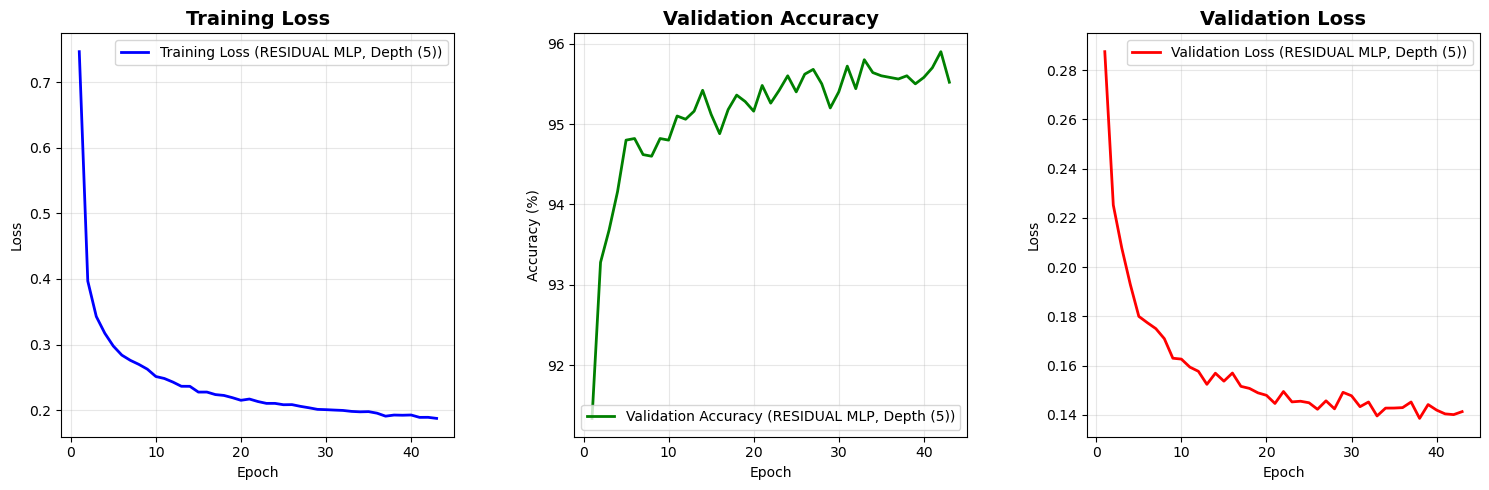

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 95.90%

Classification Report:
              precision    recall  f1-score   support

           0      0.958     0.987     0.972       980
           1      0.965     0.985     0.975      1135
           2      0.965     0.957     0.961      1032
           3      0.959     0.949     0.954      1010
           4      0.947     0.963     0.955       982
           5      0.962     0.944     0.953       892
           6      0.967     0.962     0.965       958
           7      0.956     0.958     0.957      1028
           8      0.949     0.941     0.945       974
           9      0.959     0.939     0.949      1009

    accuracy                          0.959     10000
   macro avg      0.959     0.959     0.959     10000
weighted avg      0.959     0.959     0.959     10000



best_val_acc,▁▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
best_val_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▁▁▁▁▂▁▁▁▂▃▄▁▁▂▁▂▂▃▄▁▂▃▄▅▅▁▂▂▃▄▅▅▆▇█
test_accuracy,▁
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇█████▇▇▇████▇
val_loss,█▇▇▅▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
best_val_acc,95.8
best_val_loss,0.13953


Epoch   1: Train Loss: 0.7685, Val Loss: 0.3093, Val Acc: 90.52% NEW BEST
Epoch   2: Train Loss: 0.4253, Val Loss: 0.2552, Val Acc: 92.24% NEW BEST
Epoch   3: Train Loss: 0.3710, Val Loss: 0.2280, Val Acc: 93.20% NEW BEST
Epoch   4: Train Loss: 0.3389, Val Loss: 0.2139, Val Acc: 93.54% NEW BEST
Epoch   5: Train Loss: 0.3164, Val Loss: 0.2058, Val Acc: 93.66% NEW BEST
Epoch   6: Train Loss: 0.3086, Val Loss: 0.1984, Val Acc: 94.16% NEW BEST
Epoch   7: Train Loss: 0.2962, Val Loss: 0.1883, Val Acc: 94.12% NEW BEST
Epoch   8: Train Loss: 0.2832, Val Loss: 0.1821, Val Acc: 94.44% NEW BEST
Epoch   9: Train Loss: 0.2759, Val Loss: 0.1707, Val Acc: 94.88% NEW BEST
Epoch  10: Train Loss: 0.2668, Val Loss: 0.1722, Val Acc: 94.76% (1/10)
Epoch  11: Train Loss: 0.2563, Val Loss: 0.1725, Val Acc: 94.76% (2/10)
Epoch  12: Train Loss: 0.2537, Val Loss: 0.1708, Val Acc: 94.68% (3/10)
Epoch  13: Train Loss: 0.2513, Val Loss: 0.1681, Val Acc: 94.98% NEW BEST
Epoch  14: Train Loss: 0.2477, Val Loss: 0.1

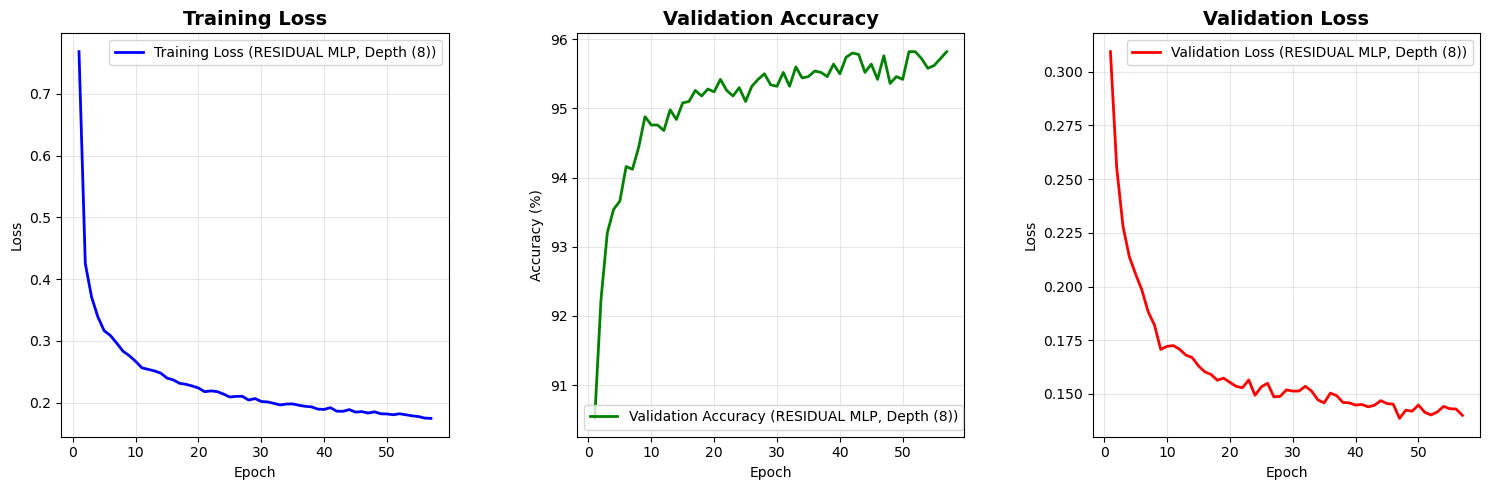

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 95.88%

Classification Report:
              precision    recall  f1-score   support

           0      0.968     0.987     0.977       980
           1      0.970     0.989     0.980      1135
           2      0.964     0.957     0.961      1032
           3      0.944     0.957     0.951      1010
           4      0.951     0.960     0.955       982
           5      0.944     0.923     0.933       892
           6      0.972     0.968     0.970       958
           7      0.959     0.945     0.951      1028
           8      0.956     0.951     0.953       974
           9      0.959     0.944     0.952      1009

    accuracy                          0.959     10000
   macro avg      0.959     0.958     0.958     10000
weighted avg      0.959     0.959     0.959     10000



best_val_acc,▁▃▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
best_val_loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▁▂▃▁▁▁▂▁▁▂▂▂▄▅▅▇▇▁▂▂▄▁▂▂▄▅▁▂▂▃▅▅▆▇█
test_accuracy,▁
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▂▂▄▃▄▅▅▇▇▇▆▆▆▇▇▇▇▇▇▇▇▇▇███▇█▇▇████▇██
val_loss,█▇▆▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
best_val_acc,95.76
best_val_loss,0.13862


Epoch   1: Train Loss: 0.8995, Val Loss: 0.3114, Val Acc: 91.16% NEW BEST
Epoch   2: Train Loss: 0.4421, Val Loss: 0.2569, Val Acc: 92.24% NEW BEST
Epoch   3: Train Loss: 0.3781, Val Loss: 0.2235, Val Acc: 92.90% NEW BEST
Epoch   4: Train Loss: 0.3464, Val Loss: 0.2080, Val Acc: 93.66% NEW BEST
Epoch   5: Train Loss: 0.3252, Val Loss: 0.2044, Val Acc: 93.62% NEW BEST
Epoch   6: Train Loss: 0.3102, Val Loss: 0.1917, Val Acc: 94.02% NEW BEST
Epoch   7: Train Loss: 0.2988, Val Loss: 0.1839, Val Acc: 94.30% NEW BEST
Epoch   8: Train Loss: 0.2880, Val Loss: 0.1849, Val Acc: 94.34% (1/10)
Epoch   9: Train Loss: 0.2832, Val Loss: 0.1770, Val Acc: 94.30% NEW BEST
Epoch  10: Train Loss: 0.2716, Val Loss: 0.1712, Val Acc: 94.60% NEW BEST
Epoch  11: Train Loss: 0.2667, Val Loss: 0.1725, Val Acc: 94.48% (1/10)
Epoch  12: Train Loss: 0.2606, Val Loss: 0.1675, Val Acc: 94.70% NEW BEST
Epoch  13: Train Loss: 0.2607, Val Loss: 0.1718, Val Acc: 94.18% (1/10)
Epoch  14: Train Loss: 0.2535, Val Loss: 0.1

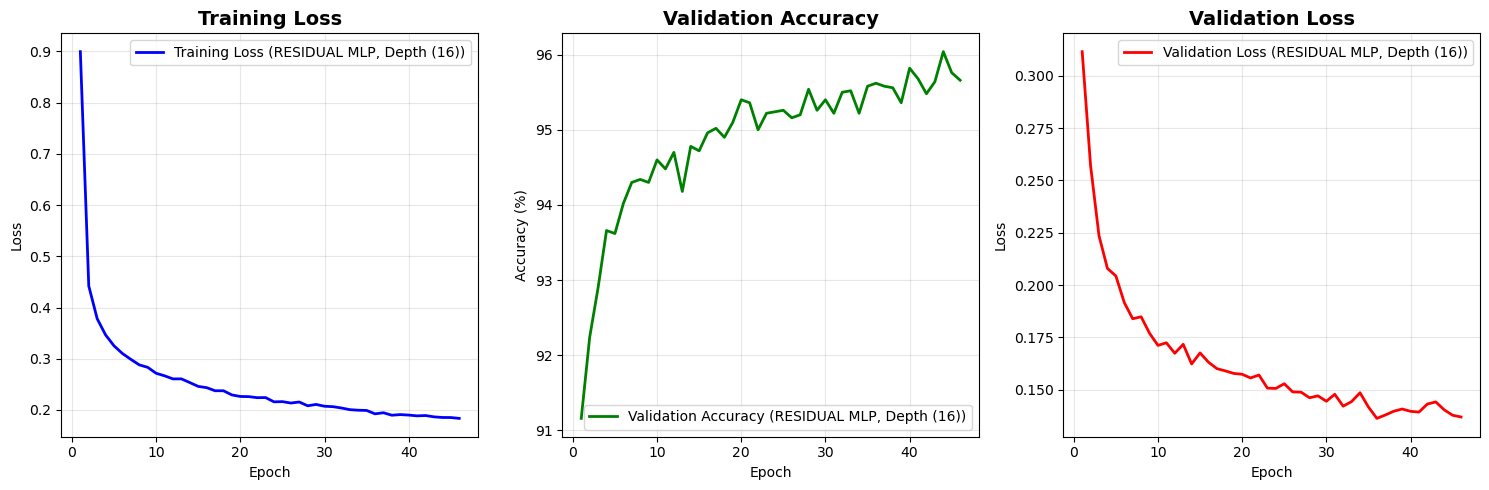

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 95.50%

Classification Report:
              precision    recall  f1-score   support

           0      0.963     0.986     0.974       980
           1      0.979     0.981     0.980      1135
           2      0.957     0.947     0.952      1032
           3      0.953     0.944     0.948      1010
           4      0.956     0.957     0.957       982
           5      0.950     0.919     0.934       892
           6      0.965     0.968     0.966       958
           7      0.954     0.953     0.954      1028
           8      0.935     0.936     0.936       974
           9      0.934     0.952     0.943      1009

    accuracy                          0.955     10000
   macro avg      0.955     0.954     0.954     10000
weighted avg      0.955     0.955     0.955     10000



best_val_acc,▁▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██▇▇▇▇████████████████
best_val_loss,█▆▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▁▁▁▁▂▁▂▁▂▁▁▁▂▁▂▂▃▁▂▁▂▁▁▂▃▃▁▂▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▃▃▅▅▅▆▆▅▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██▇
val_loss,█▆▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_acc,95.62
best_val_loss,0.13638


Epoch   1: Train Loss: 1.1001, Val Loss: 0.3212, Val Acc: 90.26% NEW BEST
Epoch   2: Train Loss: 0.4587, Val Loss: 0.2371, Val Acc: 93.00% NEW BEST
Epoch   3: Train Loss: 0.3847, Val Loss: 0.2149, Val Acc: 93.28% NEW BEST
Epoch   4: Train Loss: 0.3573, Val Loss: 0.1960, Val Acc: 94.00% NEW BEST
Epoch   5: Train Loss: 0.3296, Val Loss: 0.1919, Val Acc: 93.92% NEW BEST
Epoch   6: Train Loss: 0.3141, Val Loss: 0.1809, Val Acc: 94.30% NEW BEST
Epoch   7: Train Loss: 0.3005, Val Loss: 0.1793, Val Acc: 94.52% NEW BEST
Epoch   8: Train Loss: 0.2924, Val Loss: 0.1729, Val Acc: 94.82% NEW BEST
Epoch   9: Train Loss: 0.2824, Val Loss: 0.1729, Val Acc: 94.52% (1/10)
Epoch  10: Train Loss: 0.2753, Val Loss: 0.1699, Val Acc: 94.68% NEW BEST
Epoch  11: Train Loss: 0.2693, Val Loss: 0.1715, Val Acc: 94.60% (1/10)
Epoch  12: Train Loss: 0.2624, Val Loss: 0.1684, Val Acc: 94.86% NEW BEST
Epoch  13: Train Loss: 0.2568, Val Loss: 0.1614, Val Acc: 95.00% NEW BEST
Epoch  14: Train Loss: 0.2502, Val Loss: 0

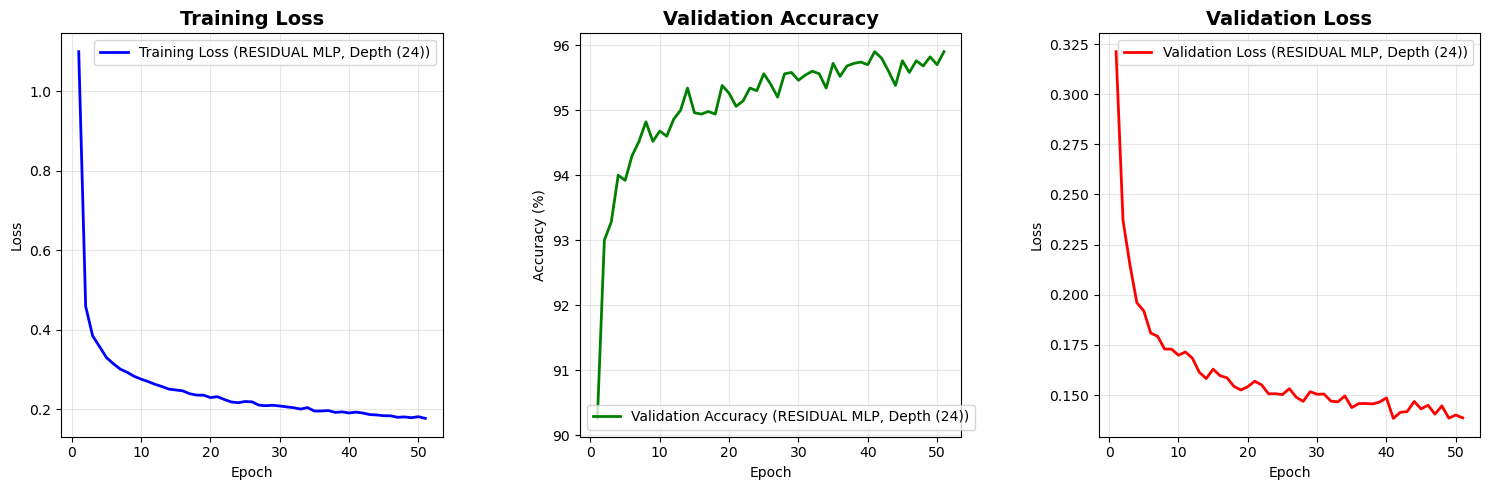

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 95.82%

Classification Report:
              precision    recall  f1-score   support

           0      0.977     0.982     0.979       980
           1      0.975     0.984     0.979      1135
           2      0.967     0.951     0.958      1032
           3      0.951     0.952     0.952      1010
           4      0.946     0.963     0.955       982
           5      0.953     0.925     0.939       892
           6      0.959     0.972     0.965       958
           7      0.964     0.947     0.956      1028
           8      0.944     0.960     0.952       974
           9      0.944     0.941     0.942      1009

    accuracy                          0.958     10000
   macro avg      0.958     0.958     0.958     10000
weighted avg      0.958     0.958     0.958     10000



best_val_acc,▁▄▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
best_val_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▁▂▁▂▁▁▂▂▃▁▂▁▂▂▃▁▂▂▃▄▅▁▂▂▃▅▁▂▂▃▅▅▆▇█
test_accuracy,▁
train_loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▆▆▆▇▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████▇████
val_loss,██▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_acc,95.9
best_val_loss,0.13838


Epoch   1: Train Loss: 0.9650, Val Loss: 0.3243, Val Acc: 90.20% NEW BEST
Epoch   2: Train Loss: 0.4655, Val Loss: 0.2504, Val Acc: 92.30% NEW BEST
Epoch   3: Train Loss: 0.4052, Val Loss: 0.2295, Val Acc: 93.22% NEW BEST
Epoch   4: Train Loss: 0.3693, Val Loss: 0.2157, Val Acc: 93.60% NEW BEST
Epoch   5: Train Loss: 0.3423, Val Loss: 0.2007, Val Acc: 93.80% NEW BEST
Epoch   6: Train Loss: 0.3219, Val Loss: 0.1934, Val Acc: 94.16% NEW BEST
Epoch   7: Train Loss: 0.3079, Val Loss: 0.1785, Val Acc: 94.28% NEW BEST
Epoch   8: Train Loss: 0.2945, Val Loss: 0.1790, Val Acc: 94.44% (1/10)
Epoch   9: Train Loss: 0.2848, Val Loss: 0.1770, Val Acc: 94.38% NEW BEST
Epoch  10: Train Loss: 0.2738, Val Loss: 0.1671, Val Acc: 94.78% NEW BEST
Epoch  11: Train Loss: 0.2619, Val Loss: 0.1606, Val Acc: 94.94% NEW BEST
Epoch  12: Train Loss: 0.2579, Val Loss: 0.1642, Val Acc: 94.66% (1/10)
Epoch  13: Train Loss: 0.2544, Val Loss: 0.1533, Val Acc: 95.10% NEW BEST
Epoch  14: Train Loss: 0.2434, Val Loss: 0

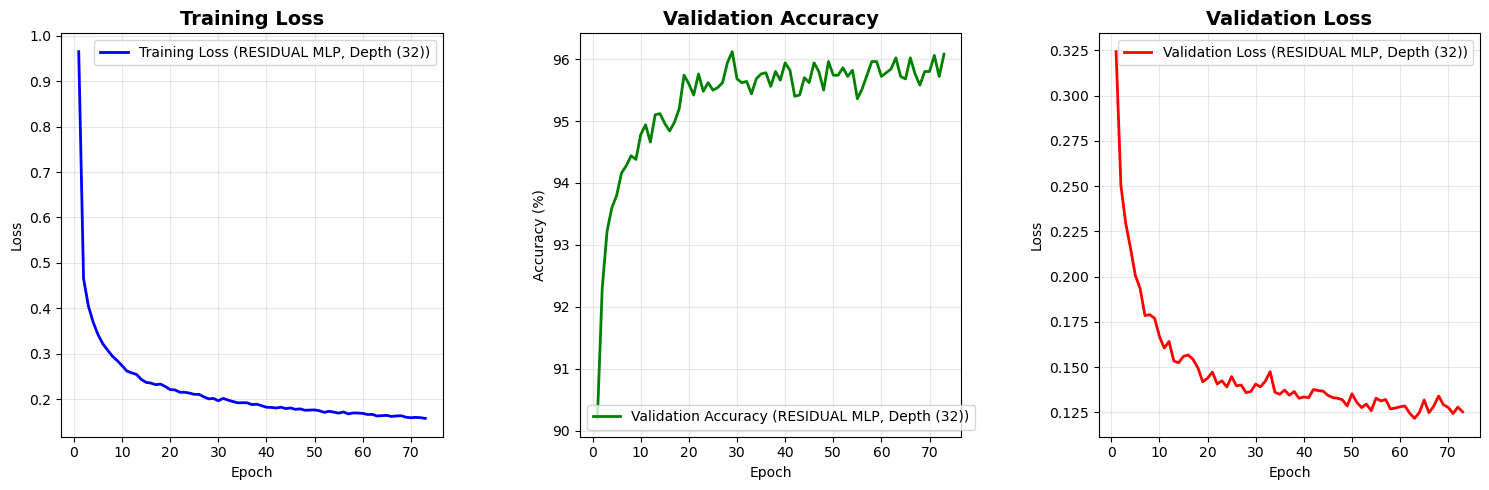

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 95.87%

Classification Report:
              precision    recall  f1-score   support

           0      0.965     0.977     0.971       980
           1      0.978     0.986     0.982      1135
           2      0.974     0.955     0.965      1032
           3      0.963     0.948     0.955      1010
           4      0.962     0.954     0.958       982
           5      0.954     0.923     0.938       892
           6      0.958     0.967     0.962       958
           7      0.956     0.960     0.958      1028
           8      0.923     0.961     0.942       974
           9      0.951     0.950     0.951      1009

    accuracy                          0.959     10000
   macro avg      0.958     0.958     0.958     10000
weighted avg      0.959     0.959     0.959     10000



best_val_acc,▁▂▃▃▃▄▅▅▅▅▇▇▇▇▇█████▇▇▇▇▇▇███▇▇▇▇▇▇▇████
best_val_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▁▁▃▁▂▁▂▃▃▂▃▄▅▆▆▃▃▄▅█▂▃▃▁▂▃▄▆▆▁▂▃▄▅▆
test_accuracy,▁
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▆▆▆▆▇▆▇█▇▇█▇██▇▇██▇▇██▇██▇█████▇████
val_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_acc,96.02
best_val_loss,0.12168


Epoch   1: Train Loss: 1.1584, Val Loss: 0.3531, Val Acc: 89.56% NEW BEST
Epoch   2: Train Loss: 0.5023, Val Loss: 0.2771, Val Acc: 91.82% NEW BEST
Epoch   3: Train Loss: 0.4158, Val Loss: 0.2390, Val Acc: 92.96% NEW BEST
Epoch   4: Train Loss: 0.3746, Val Loss: 0.2265, Val Acc: 93.20% NEW BEST
Epoch   5: Train Loss: 0.3483, Val Loss: 0.2119, Val Acc: 93.32% NEW BEST
Epoch   6: Train Loss: 0.3332, Val Loss: 0.2006, Val Acc: 94.20% NEW BEST
Epoch   7: Train Loss: 0.3135, Val Loss: 0.1966, Val Acc: 93.94% NEW BEST
Epoch   8: Train Loss: 0.3061, Val Loss: 0.1879, Val Acc: 94.34% NEW BEST
Epoch   9: Train Loss: 0.2942, Val Loss: 0.1815, Val Acc: 94.38% NEW BEST
Epoch  10: Train Loss: 0.2874, Val Loss: 0.1757, Val Acc: 94.58% NEW BEST
Epoch  11: Train Loss: 0.2717, Val Loss: 0.1720, Val Acc: 94.58% NEW BEST
Epoch  12: Train Loss: 0.2668, Val Loss: 0.1689, Val Acc: 94.56% NEW BEST
Epoch  13: Train Loss: 0.2636, Val Loss: 0.1663, Val Acc: 94.70% NEW BEST
Epoch  14: Train Loss: 0.2574, Val Los

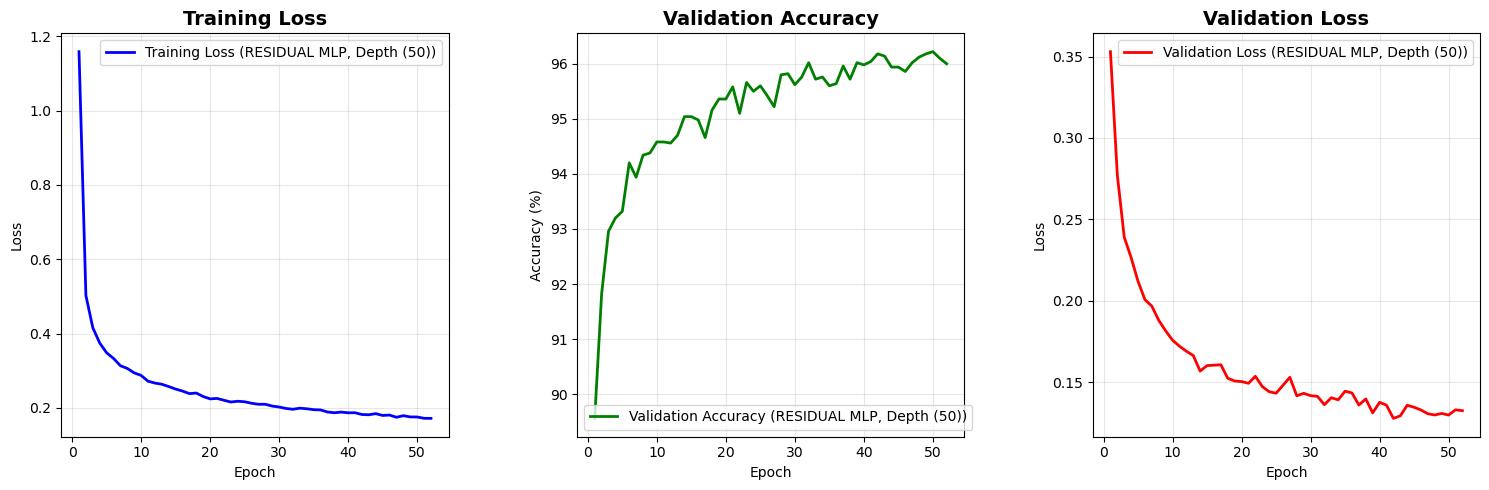

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 95.73%

Classification Report:
              precision    recall  f1-score   support

           0      0.978     0.983     0.980       980
           1      0.967     0.985     0.976      1135
           2      0.960     0.954     0.957      1032
           3      0.936     0.949     0.942      1010
           4      0.968     0.961     0.965       982
           5      0.943     0.938     0.940       892
           6      0.959     0.974     0.966       958
           7      0.965     0.935     0.950      1028
           8      0.945     0.935     0.940       974
           9      0.950     0.954     0.952      1009

    accuracy                          0.957     10000
   macro avg      0.957     0.957     0.957     10000
weighted avg      0.957     0.957     0.957     10000



best_val_acc,▁▃▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
best_val_loss,█▆▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▁▁▁▁▁▁▂▂▃▁▂▁▂▁▁▂▃▁▂▃▂▂▃▄▅▂▁▂▂▃▅▅▆▇█
test_accuracy,▁
train_loss,█▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▅▅▅▆▆▆▆▇▆▆▇▇▇▇▇▇▇█▇███▇██▇███████████
val_loss,██▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁
best_val_acc,96.18
best_val_loss,0.12764


In [15]:
# Training and evaluation of Residual MLP with varying depth
for depth in depth_values:
    name_run = "lab1_esercizio1.2_Residual_MLP - depth: " + str(depth)
    model_residual_MLP = Residual_MLP(input_size, [width]*depth, num_classes).to(device)
    optimizer = torch.optim.Adam(model_residual_MLP.parameters(), lr=lr)
    run = wandb.init(
        project="DLALabs",
        name=name_run,
        config={
            "model": "Residual-MLP",
            "epochs": 100,
            "learning_rate": 0.001,
            "batch_size": 128,
            "input_size": 28*28,
            "width": width,
            "depth": depth,
            "num_classes": 10,
            "optimizer": "Adam",
            "loss_function": "CrossEntropyLoss"
        }
    )
    run.watch(model_residual_MLP, log="gradients", log_freq=50)
    train_losses, val_accuracies, val_losses = train(model_residual_MLP, dl_train, dl_val, epochs, criterion, optimizer, device)
    print("RESIDUAL MLP")
    plot_training_metrics(train_losses=train_losses,val_accuracies=val_accuracies, val_losses=val_losses, save_path="plot", model_name="RESIDUAL MLP", model_depth=depth)
    (accuracy, _, report) = evaluate(model_residual_MLP, dl_test, device, log_wandb=True)
    
    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'\nClassification Report:\n{report}')
    wandb.finish()


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch   1: Train Loss: 0.9435, Val Loss: 0.4273, Val Acc: 89.90% NEW BEST
Epoch   2: Train Loss: 0.4288, Val Loss: 0.3027, Val Acc: 91.32% NEW BEST
Epoch   3: Train Loss: 0.3646, Val Loss: 0.2736, Val Acc: 92.04% NEW BEST
Epoch   4: Train Loss: 0.3301, Val Loss: 0.2488, Val Acc: 92.66% NEW BEST
Epoch   5: Train Loss: 0.3146, Val Loss: 0.2449, Val Acc: 92.58% NEW BEST
Epoch   6: Train Loss: 0.2998, Val Loss: 0.2337, Val Acc: 92.90% NEW BEST
Epoch   7: Train Loss: 0.2915, Val Loss: 0.2274, Val Acc: 93.12% NEW BEST
Epoch   8: Train Loss: 0.2812, Val Loss: 0.2233, Val Acc: 93.38% NEW BEST
Epoch   9: Train Loss: 0.2714, Val Loss: 0.2181, Val Acc: 93.64% NEW BEST
Epoch  10: Train Loss: 0.2682, Val Loss: 0.2226, Val Acc: 93.12% (1/10)
Epoch  11: Train Loss: 0.2590, Val Loss: 0.2122, Val Acc: 93.52% NEW BEST
Epoch  12: Train Loss: 0.2550, Val Loss: 0.2122, Val Acc: 93.68% (1/10)
Epoch  13: Train Loss: 0.2526, Val Loss: 0.2139, Val Acc: 93.52% (2/10)
Epoch  14: Train Loss: 0.2485, Val Loss: 0.2

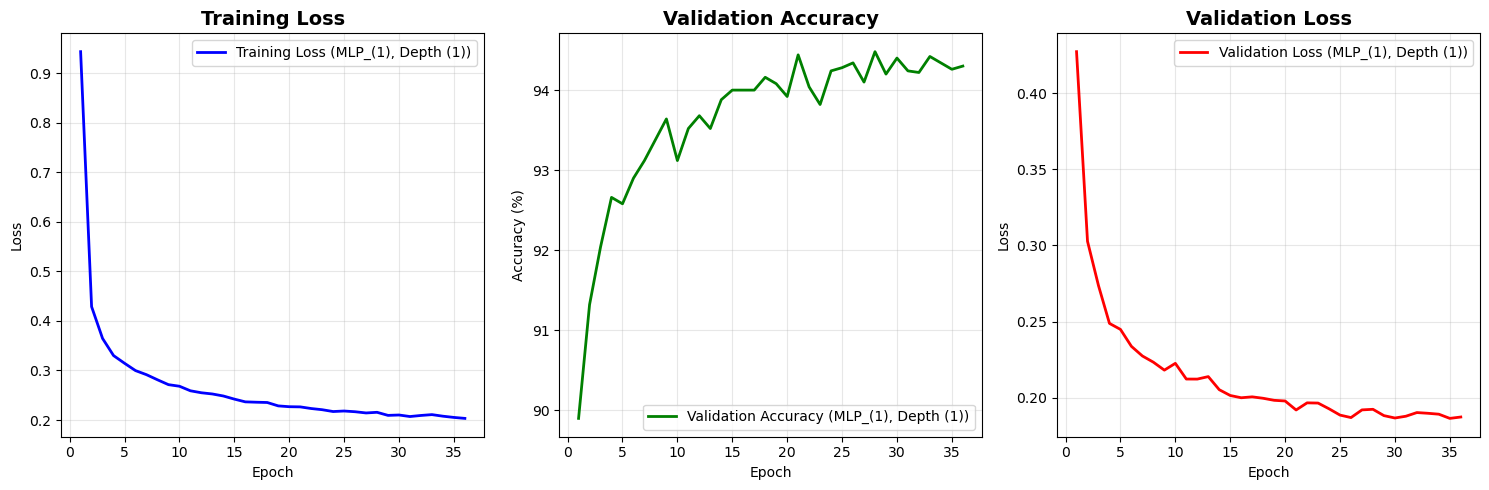

Test Accuracy: 94.94%

Classification Report:
              precision    recall  f1-score   support

           0      0.964     0.983     0.973       980
           1      0.971     0.981     0.976      1135
           2      0.955     0.944     0.949      1032
           3      0.947     0.948     0.947      1010
           4      0.944     0.948     0.946       982
           5      0.946     0.925     0.935       892
           6      0.948     0.967     0.957       958
           7      0.949     0.943     0.946      1028
           8      0.924     0.922     0.923       974
           9      0.942     0.930     0.936      1009

    accuracy                          0.949     10000
   macro avg      0.949     0.949     0.949     10000
weighted avg      0.949     0.949     0.949     10000



best_val_acc,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████
best_val_loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▁▁▁▁▂▁▂▂▁▁▁▂▂▁▂▁▂▂▃▁▁▂▂▃▄▅▅▆▇▇█
test_accuracy,▁
train_loss,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▄▄▅▅▆▆▆▇▇▆▇▇▇▇▇▇▇▇█▇▇█▇▇███▇█████████
val_loss,█▄▄▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_acc,94.34
best_val_loss,0.18693


Epoch   1: Train Loss: 1.0524, Val Loss: 0.3787, Val Acc: 91.02% NEW BEST
Epoch   2: Train Loss: 0.5148, Val Loss: 0.2799, Val Acc: 91.74% NEW BEST
Epoch   3: Train Loss: 0.4463, Val Loss: 0.2490, Val Acc: 92.90% NEW BEST
Epoch   4: Train Loss: 0.4136, Val Loss: 0.2290, Val Acc: 93.22% NEW BEST
Epoch   5: Train Loss: 0.3930, Val Loss: 0.2217, Val Acc: 93.40% NEW BEST
Epoch   6: Train Loss: 0.3817, Val Loss: 0.2237, Val Acc: 93.62% (1/10)
Epoch   7: Train Loss: 0.3703, Val Loss: 0.2164, Val Acc: 93.48% NEW BEST
Epoch   8: Train Loss: 0.3565, Val Loss: 0.2120, Val Acc: 93.68% NEW BEST
Epoch   9: Train Loss: 0.3513, Val Loss: 0.2059, Val Acc: 93.96% NEW BEST
Epoch  10: Train Loss: 0.3450, Val Loss: 0.2025, Val Acc: 93.92% NEW BEST
Epoch  11: Train Loss: 0.3439, Val Loss: 0.2027, Val Acc: 94.30% (1/10)
Epoch  12: Train Loss: 0.3328, Val Loss: 0.1947, Val Acc: 94.52% NEW BEST
Epoch  13: Train Loss: 0.3314, Val Loss: 0.2042, Val Acc: 94.10% (1/10)
Epoch  14: Train Loss: 0.3255, Val Loss: 0.1

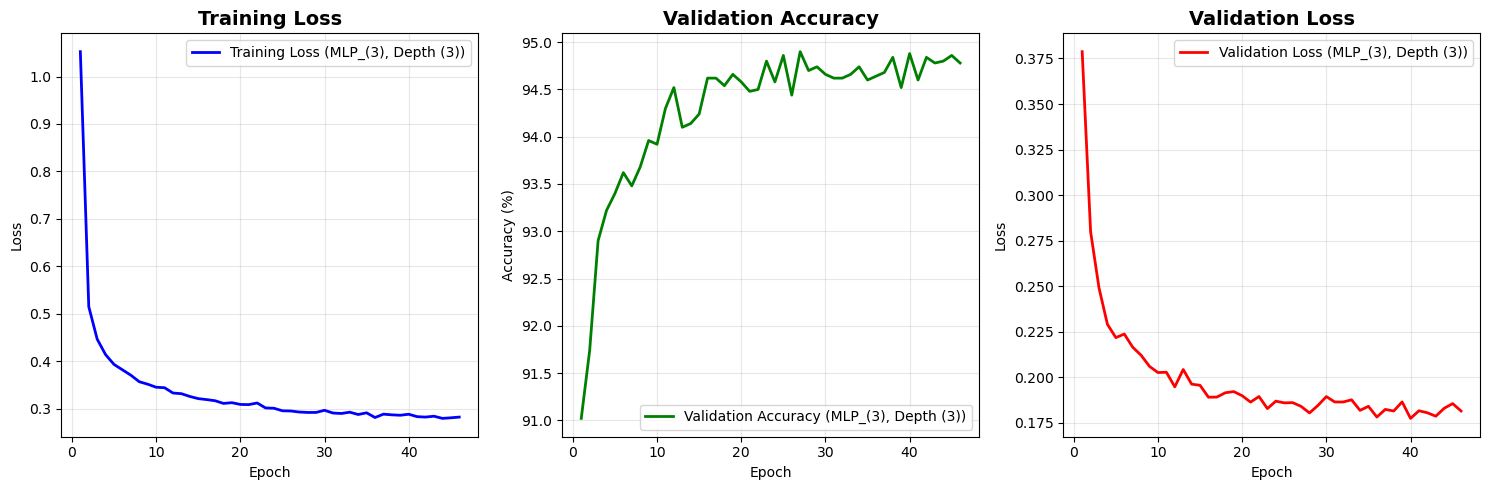

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 94.91%

Classification Report:
              precision    recall  f1-score   support

           0      0.962     0.985     0.973       980
           1      0.981     0.972     0.977      1135
           2      0.956     0.933     0.945      1032
           3      0.950     0.939     0.944      1010
           4      0.948     0.951     0.950       982
           5      0.923     0.928     0.926       892
           6      0.944     0.960     0.952       958
           7      0.956     0.949     0.953      1028
           8      0.929     0.932     0.931       974
           9      0.934     0.938     0.936      1009

    accuracy                          0.949     10000
   macro avg      0.948     0.949     0.949     10000
weighted avg      0.949     0.949     0.949     10000



best_val_acc,▁▂▄▅▅▅▆▆▆▆▇▇▇▇████▇▇████████████████████
best_val_loss,█▅▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▂▁▁▁▂▁▂▃▃▂▃▃▄▁▂▂▃▃▄▁▂▃▄▅▆▆▁▂▃▄▅▆▆▇█
test_accuracy,▁
train_loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▂▄▅▅▆▆▇▇▇▇▇▇▇▇██▇█▇▇▇▇▇█████▇█▇█▇████
val_loss,█▅▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_acc,94.64
best_val_loss,0.17809


Epoch   1: Train Loss: 1.2776, Val Loss: 0.4692, Val Acc: 89.26% NEW BEST
Epoch   2: Train Loss: 0.6841, Val Loss: 0.3151, Val Acc: 91.68% NEW BEST
Epoch   3: Train Loss: 0.5785, Val Loss: 0.2832, Val Acc: 92.34% NEW BEST
Epoch   4: Train Loss: 0.5405, Val Loss: 0.2706, Val Acc: 92.56% NEW BEST
Epoch   5: Train Loss: 0.5117, Val Loss: 0.2624, Val Acc: 92.80% NEW BEST
Epoch   6: Train Loss: 0.4931, Val Loss: 0.2603, Val Acc: 92.72% NEW BEST
Epoch   7: Train Loss: 0.4725, Val Loss: 0.2541, Val Acc: 92.94% NEW BEST
Epoch   8: Train Loss: 0.4639, Val Loss: 0.2493, Val Acc: 92.80% NEW BEST
Epoch   9: Train Loss: 0.4604, Val Loss: 0.2507, Val Acc: 92.94% (1/10)
Epoch  10: Train Loss: 0.4551, Val Loss: 0.2511, Val Acc: 92.78% (2/10)
Epoch  11: Train Loss: 0.4451, Val Loss: 0.2433, Val Acc: 93.30% NEW BEST
Epoch  12: Train Loss: 0.4363, Val Loss: 0.2469, Val Acc: 93.14% (1/10)
Epoch  13: Train Loss: 0.4339, Val Loss: 0.2360, Val Acc: 93.56% NEW BEST
Epoch  14: Train Loss: 0.4342, Val Loss: 0.2

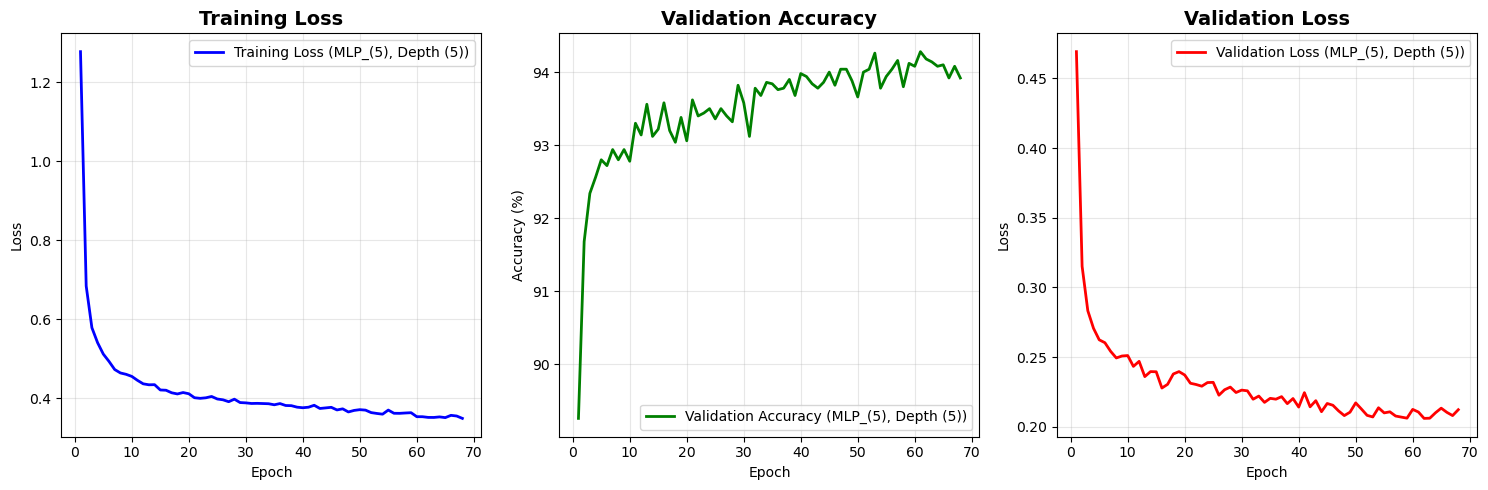

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 94.55%

Classification Report:
              precision    recall  f1-score   support

           0      0.957     0.983     0.970       980
           1      0.977     0.984     0.981      1135
           2      0.948     0.926     0.937      1032
           3      0.918     0.927     0.922      1010
           4      0.942     0.948     0.945       982
           5      0.924     0.918     0.921       892
           6      0.940     0.967     0.953       958
           7      0.973     0.941     0.956      1028
           8      0.935     0.922     0.929       974
           9      0.933     0.934     0.933      1009

    accuracy                          0.946     10000
   macro avg      0.945     0.945     0.945     10000
weighted avg      0.946     0.946     0.945     10000



best_val_acc,▁▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████████████
best_val_loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▁▂▁▁▂▃▃▄▅▆█▁▂▃▃▅▁▂▃▅▃▁▂▃▃▂▃▅▆▇▁▂▄▅█
test_accuracy,▁
train_loss,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▆▇▆▇▆▇▇▇▇▆▇▇▆▇▇▇▇▇▇▇▇▇██▇██████████
val_loss,██▆▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁
best_val_acc,93.8
best_val_loss,0.20689


Epoch   1: Train Loss: 1.5251, Val Loss: 0.7667, Val Acc: 76.00% NEW BEST
Epoch   2: Train Loss: 0.9550, Val Loss: 0.5742, Val Acc: 82.62% NEW BEST
Epoch   3: Train Loss: 0.8370, Val Loss: 0.5097, Val Acc: 81.94% NEW BEST
Epoch   4: Train Loss: 0.7624, Val Loss: 0.4738, Val Acc: 82.72% NEW BEST
Epoch   5: Train Loss: 0.7266, Val Loss: 0.4549, Val Acc: 84.02% NEW BEST
Epoch   6: Train Loss: 0.6988, Val Loss: 0.4353, Val Acc: 84.46% NEW BEST
Epoch   7: Train Loss: 0.6761, Val Loss: 0.4239, Val Acc: 84.62% NEW BEST
Epoch   8: Train Loss: 0.6544, Val Loss: 0.4197, Val Acc: 83.26% NEW BEST
Epoch   9: Train Loss: 0.6352, Val Loss: 0.4044, Val Acc: 83.60% NEW BEST
Epoch  10: Train Loss: 0.6271, Val Loss: 0.4032, Val Acc: 84.92% NEW BEST
Epoch  11: Train Loss: 0.6259, Val Loss: 0.3990, Val Acc: 83.58% NEW BEST
Epoch  12: Train Loss: 0.6157, Val Loss: 0.3930, Val Acc: 83.44% NEW BEST
Epoch  13: Train Loss: 0.6111, Val Loss: 0.3864, Val Acc: 85.34% NEW BEST
Epoch  14: Train Loss: 0.6098, Val Los

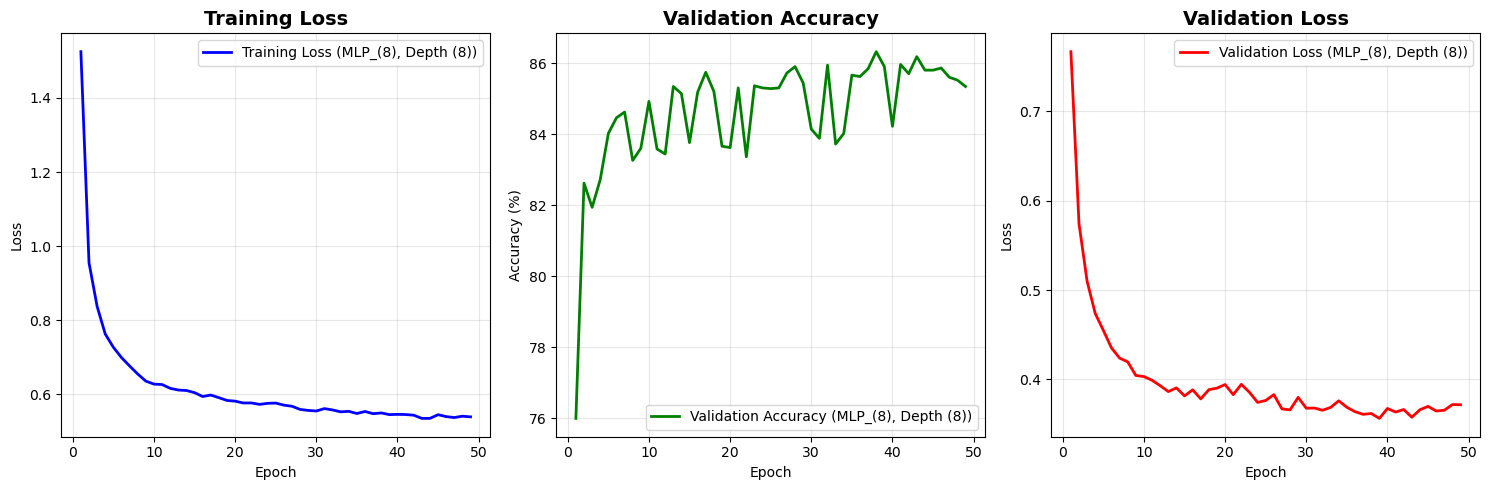

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 85.56%

Classification Report:
              precision    recall  f1-score   support

           0      0.956     0.982     0.969       980
           1      0.964     0.980     0.972      1135
           2      0.497     0.938     0.650      1032
           3      0.895     0.945     0.919      1010
           4      0.936     0.946     0.941       982
           5      0.929     0.907     0.918       892
           6      0.963     0.950     0.956       958
           7      0.964     0.945     0.954      1028
           8      0.480     0.012     0.024       974
           9      0.942     0.921     0.931      1009

    accuracy                          0.856     10000
   macro avg      0.853     0.852     0.823     10000
weighted avg      0.853     0.856     0.825     10000



best_val_acc,▁▆▅▆▇▇▆▆▇▆██▆▆██████████████████████████
best_val_loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▃▄▅▅▂▂▁▂▂▄▅▅▆▁▂▁▂▂▃▅▅▆▇█
test_accuracy,▁
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▆▆▇▇▇▆▆▆▆▇▇▆▇█▇▆▆▇▇▇██▇▇▇█▆████▇███▇▇
val_loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_acc,85.9
best_val_loss,0.35644


Epoch   1: Train Loss: 2.1701, Val Loss: 1.6621, Val Acc: 39.72% NEW BEST
Epoch   2: Train Loss: 1.6780, Val Loss: 1.2521, Val Acc: 49.40% NEW BEST
Epoch   3: Train Loss: 1.4263, Val Loss: 1.0797, Val Acc: 59.28% NEW BEST
Epoch   4: Train Loss: 1.3116, Val Loss: 0.9619, Val Acc: 65.00% NEW BEST
Epoch   5: Train Loss: 1.2078, Val Loss: 0.8887, Val Acc: 63.74% NEW BEST
Epoch   6: Train Loss: 1.1374, Val Loss: 0.8039, Val Acc: 66.36% NEW BEST
Epoch   7: Train Loss: 1.0941, Val Loss: 0.7895, Val Acc: 65.50% NEW BEST
Epoch   8: Train Loss: 1.0860, Val Loss: 0.8054, Val Acc: 63.96% (1/10)
Epoch   9: Train Loss: 1.0480, Val Loss: 0.7838, Val Acc: 65.92% NEW BEST
Epoch  10: Train Loss: 1.0324, Val Loss: 0.8031, Val Acc: 65.42% (1/10)
Epoch  11: Train Loss: 1.0334, Val Loss: 0.7649, Val Acc: 66.62% NEW BEST
Epoch  12: Train Loss: 1.0255, Val Loss: 0.7687, Val Acc: 66.32% (1/10)
Epoch  13: Train Loss: 1.0175, Val Loss: 0.7497, Val Acc: 66.52% NEW BEST
Epoch  14: Train Loss: 0.9944, Val Loss: 0.7

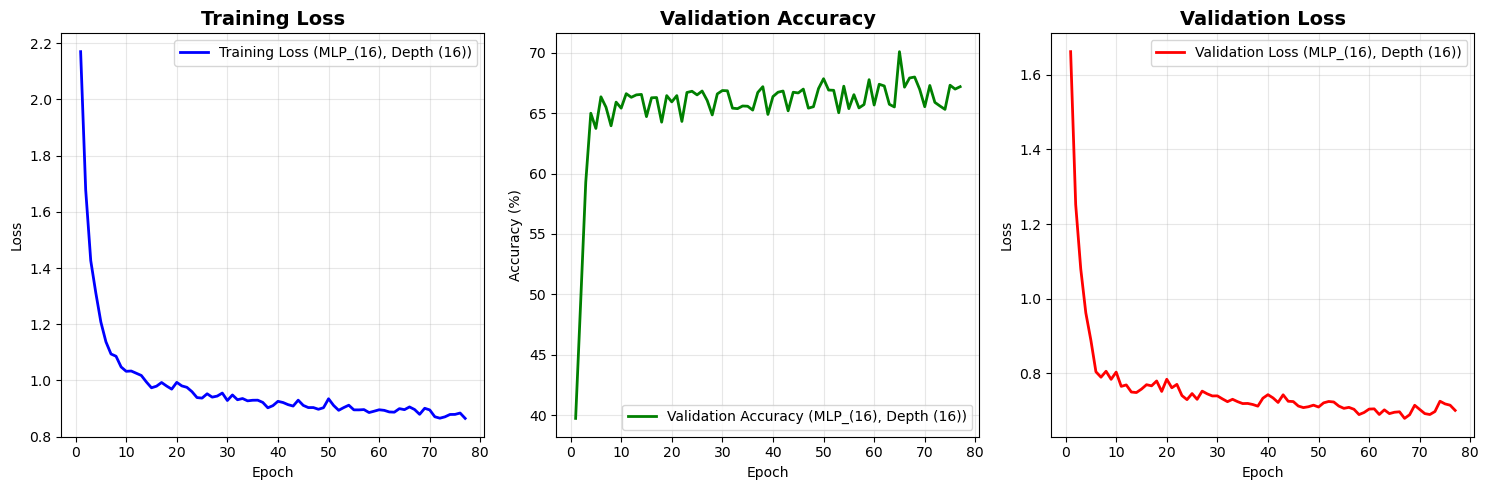

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 68.04%

Classification Report:
              precision    recall  f1-score   support

           0      0.945     0.980     0.962       980
           1      0.972     0.971     0.971      1135
           2      0.516     0.123     0.199      1032
           3      0.504     0.954     0.660      1010
           4      0.479     0.964     0.640       982
           5      0.000     0.000     0.000       892
           6      0.510     0.924     0.658       958
           7      0.936     0.946     0.941      1028
           8      0.899     0.868     0.883       974
           9      0.500     0.001     0.002      1009

    accuracy                          0.680     10000
   macro avg      0.626     0.673     0.592     10000
weighted avg      0.637     0.680     0.600     10000



best_val_acc,▁▇▆▇▇▇▇█▇▇████▇▇███████▇▇▇▇▇▇▇▇▇▇▇▇█████
best_val_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▁▁▁▁▂▄▅▆▇▁▃▄▅▅▆▂▁▁▁▂▂▃▄▆▁▁▁▂▃▄▂▂▄▆█
test_accuracy,▁
train_loss,█▆▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇▇
val_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_acc,67.92
best_val_loss,0.67905


Epoch   1: Train Loss: 2.3154, Val Loss: 2.2999, Val Acc: 11.38% NEW BEST
Epoch   2: Train Loss: 2.2740, Val Loss: 2.2671, Val Acc: 13.54% NEW BEST
Epoch   3: Train Loss: 2.1523, Val Loss: 2.0780, Val Acc: 23.60% NEW BEST
Epoch   4: Train Loss: 2.0454, Val Loss: 1.9934, Val Acc: 21.44% NEW BEST
Epoch   5: Train Loss: 1.9664, Val Loss: 1.8417, Val Acc: 28.42% NEW BEST
Epoch   6: Train Loss: 1.9106, Val Loss: 1.8228, Val Acc: 29.98% NEW BEST
Epoch   7: Train Loss: 1.9023, Val Loss: 1.8831, Val Acc: 26.26% (1/10)
Epoch   8: Train Loss: 1.8716, Val Loss: 1.7089, Val Acc: 36.30% NEW BEST
Epoch   9: Train Loss: 1.8025, Val Loss: 1.6487, Val Acc: 37.02% NEW BEST
Epoch  10: Train Loss: 1.7861, Val Loss: 1.6499, Val Acc: 37.64% (1/10)
Epoch  11: Train Loss: 1.7816, Val Loss: 1.6402, Val Acc: 38.44% NEW BEST
Epoch  12: Train Loss: 1.7898, Val Loss: 1.5937, Val Acc: 37.76% NEW BEST
Epoch  13: Train Loss: 1.7426, Val Loss: 1.5393, Val Acc: 37.82% NEW BEST
Epoch  14: Train Loss: 1.7682, Val Loss: 1

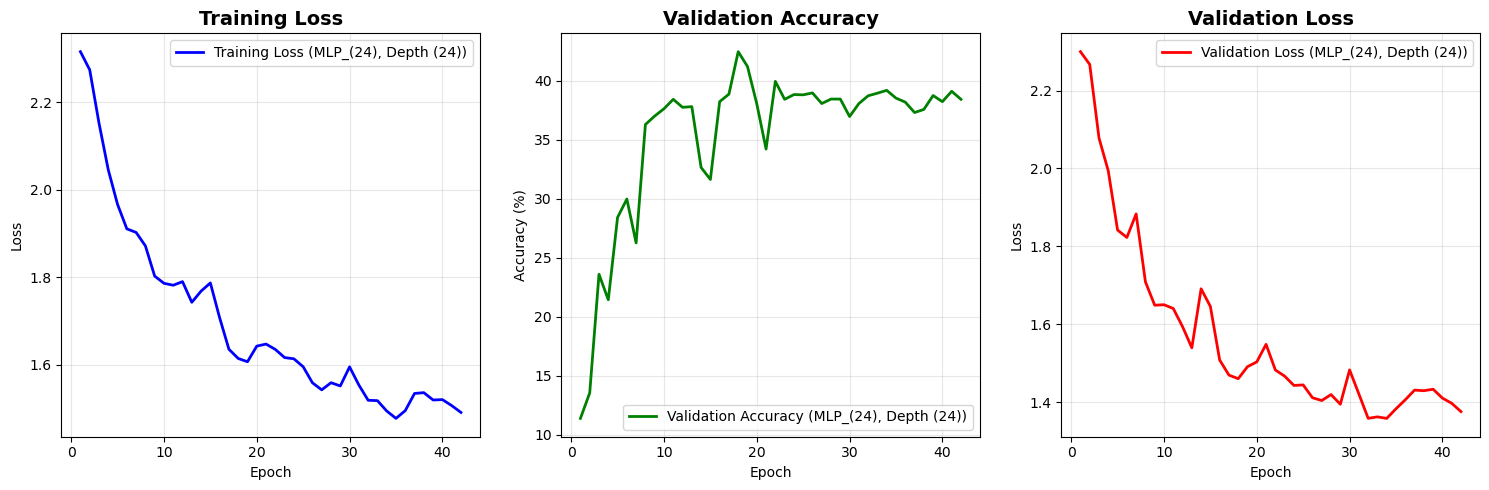

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 39.35%

Classification Report:
              precision    recall  f1-score   support

           0      0.902     0.948     0.924       980
           1      0.371     0.948     0.533      1135
           2      0.000     0.000     0.000      1032
           3      0.313     0.956     0.471      1010
           4      0.000     0.000     0.000       982
           5      0.000     0.000     0.000       892
           6      0.000     0.000     0.000       958
           7      0.323     0.938     0.481      1028
           8      0.000     0.000     0.000       974
           9      0.000     0.000     0.000      1009

    accuracy                          0.394     10000
   macro avg      0.191     0.379     0.241     10000
weighted avg      0.195     0.394     0.248     10000



best_val_acc,▁▁▄▃▅▅▅▇▇▇▇▇▇▇▇▇▇█████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
best_val_loss,██▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▁▂▁▁▂▁▁▁▂▂▁▁▁▂▂▄▅▁▂▁▁▂▁▂▂▁▂▂▃▄▅▅▆▇█
test_accuracy,▁
train_loss,██▇▆▅▅▅▄▄▄▄▄▃▃▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▄▃▅▄▇▇▇▇▇▇▆▆▆▇▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
val_loss,██▆▆▅▄▅▄▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁
best_val_acc,38.74
best_val_loss,1.35811


Epoch   1: Train Loss: 2.3172, Val Loss: 2.3016, Val Acc: 11.42% NEW BEST
Epoch   2: Train Loss: 2.3048, Val Loss: 2.3019, Val Acc: 11.20% (1/10)


KeyboardInterrupt: 

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x75325ceefa60>> (for post_run_cell), with arguments args (<ExecutionResult object at 753296ffd3c0, execution_count=11 error_before_exec=None error_in_exec= info=<ExecutionInfo object at 753296ffe830, raw_cell="# Training and evaluation of MLP with varying dept.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/eledaveri/DLA/repo_fatta_bene/DLALabs/Lab1/Lab1-CNNs.ipynb#X31sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
# Training and evaluation of MLP with varying depth
depth_values = [1, 3, 5, 8, 16]
for depth in depth_values:
    name_run = "lab1_esercizio1.2_MLP - depth: " + str(depth)
    model_MLP = My_Configurable_MLP(input_size, [width]*depth, num_classes).to(device)
    optimizer = torch.optim.Adam(model_MLP.parameters(), lr=lr)
    run = wandb.init(
        project="lab1",
        name=name_run,
        config={
            "model": "MLP",
            "epochs": 100,
            "learning_rate": 0.001,
            "batch_size": 128,
            "input_size": 28*28,
            "width": width,
            "depth": depth,
            "num_classes": 10,
            "optimizer": "Adam",
            "loss_function": "CrossEntropyLoss"
        }
    )   
    run.watch(model_MLP, log="gradients", log_freq=50)
    train_losses, val_accuracies, val_losses = train(model_MLP, dl_train, dl_val, epochs, criterion, optimizer, device)
    print("MLP")
    plot_training_metrics(train_losses=train_losses,val_accuracies=val_accuracies, val_losses=val_losses, save_path=f"plot", model_name=f"MLP_({depth})", model_depth=depth)
    (accuracy, _, report) = evaluate(model_MLP, dl_test, device, log_wandb=True)

    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'\nClassification Report:\n{report}')
    wandb.finish()








### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving. 

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [ ]:
class My_Configurable_CNN(nn.Module):
    def __init__(self, input_size, input_channels, hidden_channels, num_classes, dropout_rate=0.3):
        """
        A configurable CNN with convolutional blocks, batch normalization, dropout, and global average pooling.
        Args:
            input_size: tuple (H, W) of the input image size
            input_channels: number of input channels (e.g., 1 for grayscale, 3 for RGB)
            hidden_channels: list of integers defining the number of channels in each conv block
            num_classes: number of output classes
            dropout_rate: dropout rate to apply after conv blocks and before the classifier (default: 0.3)
        """
        super(My_Configurable_CNN, self).__init__()
        self.features = nn.ModuleList()
        layer_input_channels = input_channels
        h, w = input_size
        min_spatial_dim = 4

        # Convolutional blocks with BatchNorm e Dropout
        for i, layer_size in enumerate(hidden_channels[:-1]):
            # First conv block
            self.features.append(nn.Conv2d(layer_input_channels, layer_size, kernel_size=3, padding=1))
            self.features.append(nn.BatchNorm2d(layer_size))
            self.features.append(nn.ReLU(inplace=True))
            
            # Second conv block
            self.features.append(nn.Conv2d(layer_size, layer_size, kernel_size=3, padding=1))
            self.features.append(nn.BatchNorm2d(layer_size))
            self.features.append(nn.ReLU(inplace=True))
            
            # Dropout for regularization
            if dropout_rate > 0:
                self.features.append(nn.Dropout2d(dropout_rate * 0.5))  # Lower dropout in early layers
            
            # MaxPooling if the spatial dimensions allow it
            if h > min_spatial_dim and w > min_spatial_dim:
                self.features.append(nn.MaxPool2d(kernel_size=2, stride=2))
                h //= 2
                w //= 2
            
            layer_input_channels = layer_size

        # Last convolutional layers with higher depth
        self.final_conv1 = nn.Conv2d(layer_input_channels, hidden_channels[-1], kernel_size=3, padding=1)
        self.final_bn1 = nn.BatchNorm2d(hidden_channels[-1])
        self.final_conv2 = nn.Conv2d(hidden_channels[-1], hidden_channels[-1], kernel_size=3, padding=1)
        self.final_bn2 = nn.BatchNorm2d(hidden_channels[-1])
        
        # Global Average Pooling
        # replaces the final convolutional fully connected layers with an average of all spatial values
        # of each channel, transforming a C×H×W feature map into a C vector.
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        # Classifier with Dropout
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(hidden_channels[-1], num_classes)

    def forward(self, x, return_cam=False):
        # Foward through the feature layers
        for layer in self.features:
            x = layer(x)
        
        # Final convolutional layers
        x = F.relu(self.final_bn1(self.final_conv1(x)), inplace=True)
        features = F.relu(self.final_bn2(self.final_conv2(x)), inplace=True)
        
        # GAP and classifier
        # we need GAP for CAM
        x = self.gap(features)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        logits = self.classifier(x)
        
        if return_cam:
            return logits, features
        return logits

    def get_cam(self, features, class_idx):
        """ Compute Class Activation Map (CAM) for a given class index.
        Args:
            features: feature maps from the last convolutional layer (B, C, H, W)
            class_idx: index of the class for which to compute the CAM
        Returns:
            cam: Class Activation Map (B, H, W)
        """
        # Obtain classifier weights for the specified class
        weights = self.classifier.weight[class_idx].view(-1, 1, 1)  # Reshape for broadcasting
        # CAM computation (element-wise multiplication and sum over channels)
        cam = (weights * features).sum(dim=1)  
        return cam

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        """ A basic Residual Block with two convolutional layers and a shortcut connection.
        Args:
            in_channels: number of input channels
            out_channels: number of output channels
            stride: stride for the first convolutional layer (default: 1)
        """
        super().__init__()
        
        # Firse conv (with possible downsampling)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Second conv with stride=1
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection for matching dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        # Save input for the shortcut connection
        identity = x
        
        # First conv + bn + relu
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        # Second conv + bn (senza ReLU)
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Shortcut connection
        identity = self.shortcut(identity)
        
        # Residual sum + final ReLU 
        out += identity
        out = F.relu(out)
            
        return out

class My_Residual_CNN(nn.Module):
    def __init__(self, input_size, input_channels, hidden_channels, num_classes, dropout_rate=0.3):
        """
        A CNN with Residual Blocks, BatchNorm, Dropout, and Global Average Pooling.
        Args:
            input_size: tuple (H, W) of the input image size
            input_channels: number of input channels (e.g., 1 for grayscale, 3 for RGB)
            hidden_channels: list of integers defining the number of channels in each Residual Block
            num_classes: number of output classes
            dropout_rate: dropout rate to apply before the classifier (default: 0.3)
        """
        super().__init__()
        
        self.features = nn.ModuleList()
        h, w = input_size
        in_channels = input_channels
        min_spatial_dim = 4
        
        # Feature extraction layers with ResidualBlock
        for out_channels in hidden_channels[:-1]:
            # Dowsampling if spatial dimensions allow it
            apply_downsampling = h > min_spatial_dim and w > min_spatial_dim
            stride = 2 if apply_downsampling else 1
            
            # Add ResidualBlock
            self.features.append(ResidualBlock(in_channels, out_channels, stride=stride))
            
            if apply_downsampling:
                h //= 2
                w //= 2
            
            in_channels = out_channels
        
        # Final convolutional layer for CAM (without downsampling)
        self.final_conv = ResidualBlock(in_channels, hidden_channels[-1], stride=1)
        
        # Global Average Pooling and classifier
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(hidden_channels[-1], num_classes)
    
    def forward(self, x, return_cam=False):
        # Feature extraction
        for layer in self.features:
            x = layer(x)
        
        # Final convolutional layer
        features = self.final_conv(x)
        
        # Classification
        x = self.gap(features)
        x = x.flatten(1)
        x = self.dropout(x)
        logits = self.classifier(x)
        
        if return_cam:
            return logits, features
        return logits
    
    def get_cam(self, features, class_idx):
        """ Compute Class Activation Map (CAM) for a given class index.
        Args: 
            features: feature maps from the last convolutional layer (B, C, H, W)
            class_idx: index of the class for which to compute the CAM
        Returns:
            cam: Class Activation Map (B, H, W)
        """
        # Get the classifier weights for the specified class
        weights = self.classifier.weight[class_idx].view(-1, 1, 1)
    
        # Compute CAM (element-wise multiplication and sum over channels)
        cam = (weights * features).sum(dim=1)
    
        #Normalization
        batch_size = cam.size(0)
        for i in range(batch_size):
            cam_min = cam[i].min()
            cam_max = cam[i].max()
            if cam_max > cam_min:  
                cam[i] = (cam[i] - cam_min) / (cam_max - cam_min)
            else:
                cam[i] = torch.zeros_like(cam[i])
    
        return cam
    

In [11]:
# Load CIFAR-10 dataset
transform_cifar10 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

ds_train = CIFAR10(root='./data', train=True, download=True, transform=transform_cifar10)
ds_test = CIFAR10(root='./data', train=False, download=True, transform=transform_cifar10)

val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])



100%|██████████| 170M/170M [00:11<00:00, 15.4MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [12]:
# Training hyperparameters and training of a CNN with varying depth
device = 'cuda' if torch.cuda.is_available else 'cpu'
batch_size = 128
epochs = 50
input_size = (32, 32)  # CIFAR-10 images are 32x32
input_channels = 3  # CIFAR-10 images have 3 channels (RGB)
num_classes = 10
# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

criterion = nn.CrossEntropyLoss()


wandb: Currently logged in as: elena-daveri00 (elena-daveri00-universit-di-firenze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch   1: Train Loss: 1.8321, Val Loss: 1.6260, Val Acc: 41.62% NEW BEST
Epoch   2: Train Loss: 1.6152, Val Loss: 1.4591, Val Acc: 45.52% NEW BEST
Epoch   3: Train Loss: 1.4986, Val Loss: 1.4250, Val Acc: 46.22% NEW BEST
Epoch   4: Train Loss: 1.4329, Val Loss: 1.2394, Val Acc: 56.66% NEW BEST
Epoch   5: Train Loss: 1.3942, Val Loss: 1.1945, Val Acc: 58.06% NEW BEST
Epoch   6: Train Loss: 1.3586, Val Loss: 1.2000, Val Acc: 57.42% (1/10)
Epoch   7: Train Loss: 1.3401, Val Loss: 1.2772, Val Acc: 53.46% (2/10)
Epoch   8: Train Loss: 1.3178, Val Loss: 1.1690, Val Acc: 60.24% NEW BEST
Epoch   9: Train Loss: 1.3007, Val Loss: 1.1646, Val Acc: 58.14% NEW BEST
Epoch  10: Train Loss: 1.2901, Val Loss: 1.1618, Val Acc: 59.00% NEW BEST
Epoch  11: Train Loss: 1.2738, Val Loss: 1.5116, Val Acc: 46.24% (1/10)
Epoch  12: Train Loss: 1.2627, Val Loss: 1.1704, Val Acc: 58.74% (2/10)
Epoch  13: Train Loss: 1.2549, Val Loss: 1.3105, Val Acc: 52.42% (3/10)
Epoch  14: Train Loss: 1.2479, Val Loss: 1.0700,

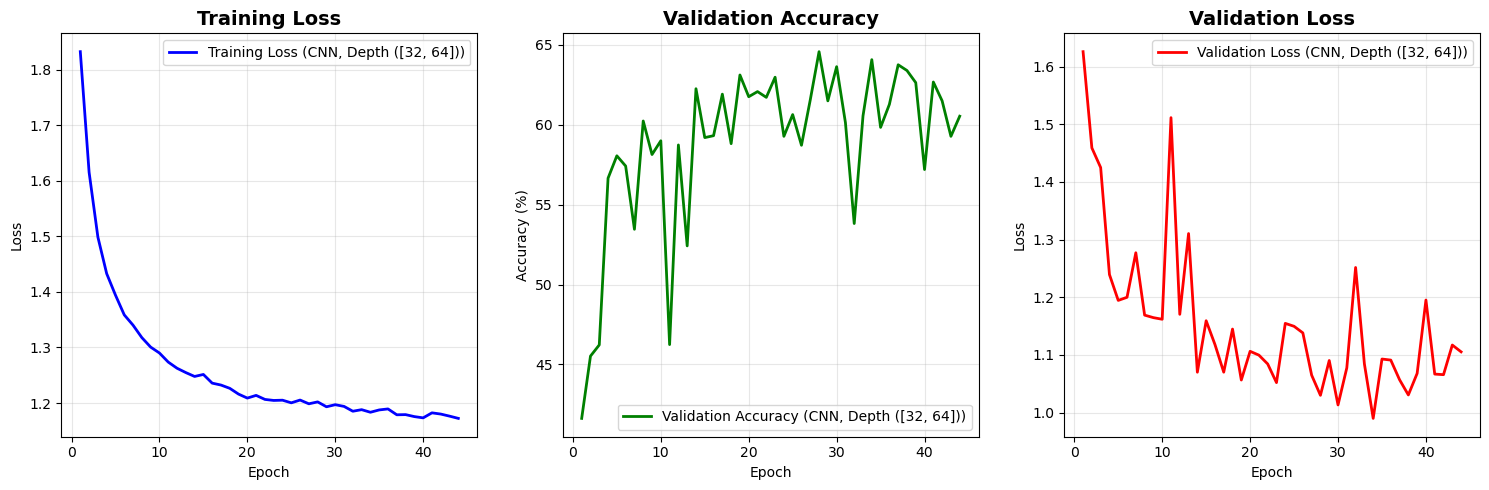

Test Accuracy: 64.24%

Classification Report:
              precision    recall  f1-score   support

           0      0.693     0.553     0.615      1000
           1      0.779     0.914     0.841      1000
           2      0.567     0.405     0.473      1000
           3      0.439     0.374     0.404      1000
           4      0.526     0.617     0.568      1000
           5      0.529     0.569     0.548      1000
           6      0.627     0.776     0.694      1000
           7      0.759     0.666     0.710      1000
           8      0.641     0.883     0.743      1000
           9      0.923     0.667     0.774      1000

    accuracy                          0.642     10000
   macro avg      0.648     0.642     0.637     10000
weighted avg      0.648     0.642     0.637     10000



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_acc,▁▂▂▆▆▆▆▇▆▆▆▆▇▇▇▇▇███████████████████████
best_val_loss,█▆▆▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▂▂▁▁▁▂▃▁▂▂▃▄▁▂▂▁▂▂▃▄▁▂▁▂▂▁▂▂▃▄▅▅▆▇█
test_accuracy,▁
train_loss,█▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▆▆▆▆▆▅▇▆▆▂▂▆▇▆▆▆▇▇█▇▇▇▆▆▇▇█▇▅█▇▇▇█▇▇▆▇
val_loss,██▆▄▃▃▃▃▃▃▂▂▃▃▂▂▃▂▂▂▂▂▂▃▃▂▂▁▄▂▁▁▂▂▂▂▃▂▂▂
best_val_acc,64.08
best_val_loss,0.98987


Epoch   1: Train Loss: 1.7940, Val Loss: 1.4741, Val Acc: 45.76% NEW BEST
Epoch   2: Train Loss: 1.4677, Val Loss: 1.2867, Val Acc: 53.28% NEW BEST
Epoch   3: Train Loss: 1.3005, Val Loss: 1.0871, Val Acc: 61.70% NEW BEST
Epoch   4: Train Loss: 1.2073, Val Loss: 1.0097, Val Acc: 64.02% NEW BEST
Epoch   5: Train Loss: 1.1259, Val Loss: 0.9608, Val Acc: 66.36% NEW BEST
Epoch   6: Train Loss: 1.0734, Val Loss: 0.9091, Val Acc: 67.92% NEW BEST
Epoch   7: Train Loss: 1.0204, Val Loss: 0.8485, Val Acc: 71.20% NEW BEST
Epoch   8: Train Loss: 0.9807, Val Loss: 0.9254, Val Acc: 67.54% (1/10)
Epoch   9: Train Loss: 0.9507, Val Loss: 0.8698, Val Acc: 69.72% (2/10)
Epoch  10: Train Loss: 0.9181, Val Loss: 0.8355, Val Acc: 71.44% NEW BEST
Epoch  11: Train Loss: 0.8950, Val Loss: 0.6936, Val Acc: 75.80% NEW BEST
Epoch  12: Train Loss: 0.8730, Val Loss: 0.7170, Val Acc: 74.68% (1/10)
Epoch  13: Train Loss: 0.8488, Val Loss: 0.7204, Val Acc: 74.82% (2/10)
Epoch  14: Train Loss: 0.8501, Val Loss: 0.727

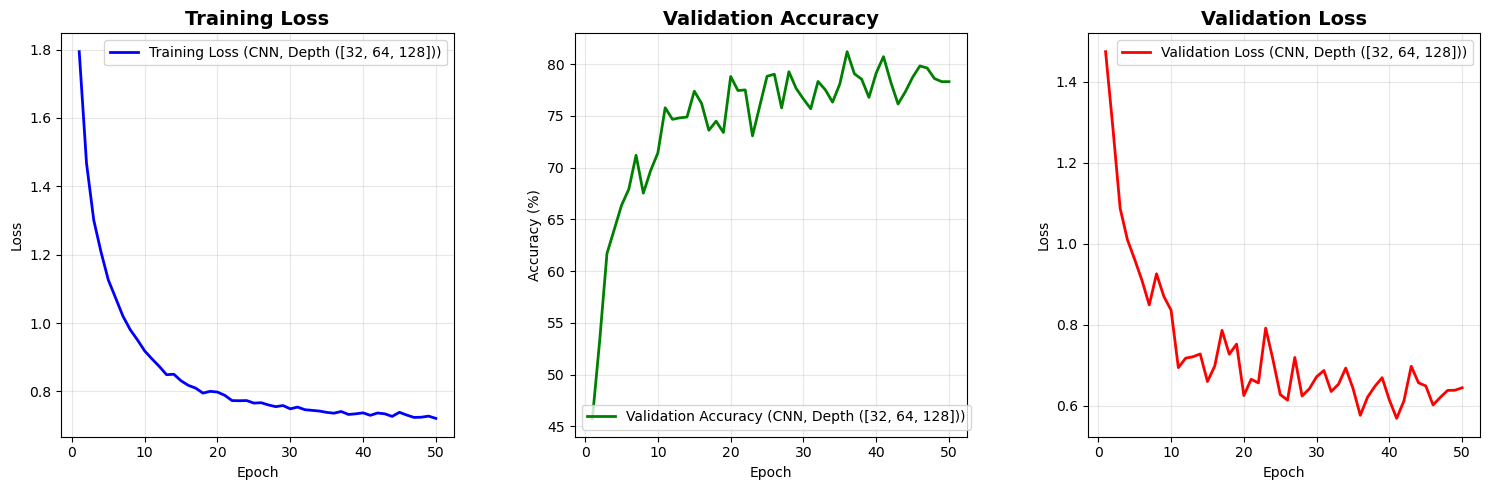

Test Accuracy: 80.46%

Classification Report:
              precision    recall  f1-score   support

           0      0.825     0.807     0.816      1000
           1      0.931     0.906     0.918      1000
           2      0.710     0.716     0.713      1000
           3      0.722     0.594     0.652      1000
           4      0.744     0.832     0.786      1000
           5      0.831     0.640     0.723      1000
           6      0.776     0.886     0.827      1000
           7      0.842     0.855     0.848      1000
           8      0.865     0.874     0.870      1000
           9      0.806     0.936     0.866      1000

    accuracy                          0.805     10000
   macro avg      0.805     0.805     0.802     10000
weighted avg      0.805     0.805     0.802     10000



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_acc,▁▂▄▅▅▆▆▆▆▇▇▇▇▇▇▇████████████████████████
best_val_loss,█▇▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▁▂▃▁▁▃▃▁▂▃▄▁▂▃▃▅▁▂▃▄▆▆▇█▁▃▃▄▁▂▃▄▅▆█
test_accuracy,▁
train_loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▅▅▅▆▆▅▆▇▇▇▇▇▇▇▇█▇▆▇██▇▇▇▇██▇████▇▇███
val_loss,██▆▅▅▄▄▄▂▂▂▂▃▃▃▂▂▂▃▂▁▂▂▂▂▂▂▁▂▂▂▁▁▂▂▁▁▂▂▂
best_val_acc,80.74
best_val_loss,0.56822


Epoch   1: Train Loss: 1.7946, Val Loss: 1.4997, Val Acc: 43.58% NEW BEST
Epoch   2: Train Loss: 1.4359, Val Loss: 1.2712, Val Acc: 53.68% NEW BEST
Epoch   3: Train Loss: 1.2206, Val Loss: 1.0318, Val Acc: 62.08% NEW BEST
Epoch   4: Train Loss: 1.0781, Val Loss: 0.9437, Val Acc: 66.00% NEW BEST
Epoch   5: Train Loss: 0.9791, Val Loss: 0.8322, Val Acc: 71.64% NEW BEST
Epoch   6: Train Loss: 0.9016, Val Loss: 0.7488, Val Acc: 73.66% NEW BEST
Epoch   7: Train Loss: 0.8533, Val Loss: 0.8137, Val Acc: 72.20% (1/10)
Epoch   8: Train Loss: 0.8111, Val Loss: 0.7292, Val Acc: 73.96% NEW BEST
Epoch   9: Train Loss: 0.7797, Val Loss: 0.7265, Val Acc: 74.76% NEW BEST
Epoch  10: Train Loss: 0.7552, Val Loss: 0.7015, Val Acc: 75.22% NEW BEST
Epoch  11: Train Loss: 0.7320, Val Loss: 0.6370, Val Acc: 78.02% NEW BEST
Epoch  12: Train Loss: 0.7182, Val Loss: 0.6634, Val Acc: 76.68% (1/10)
Epoch  13: Train Loss: 0.7089, Val Loss: 0.6574, Val Acc: 78.06% (2/10)
Epoch  14: Train Loss: 0.6935, Val Loss: 0.6

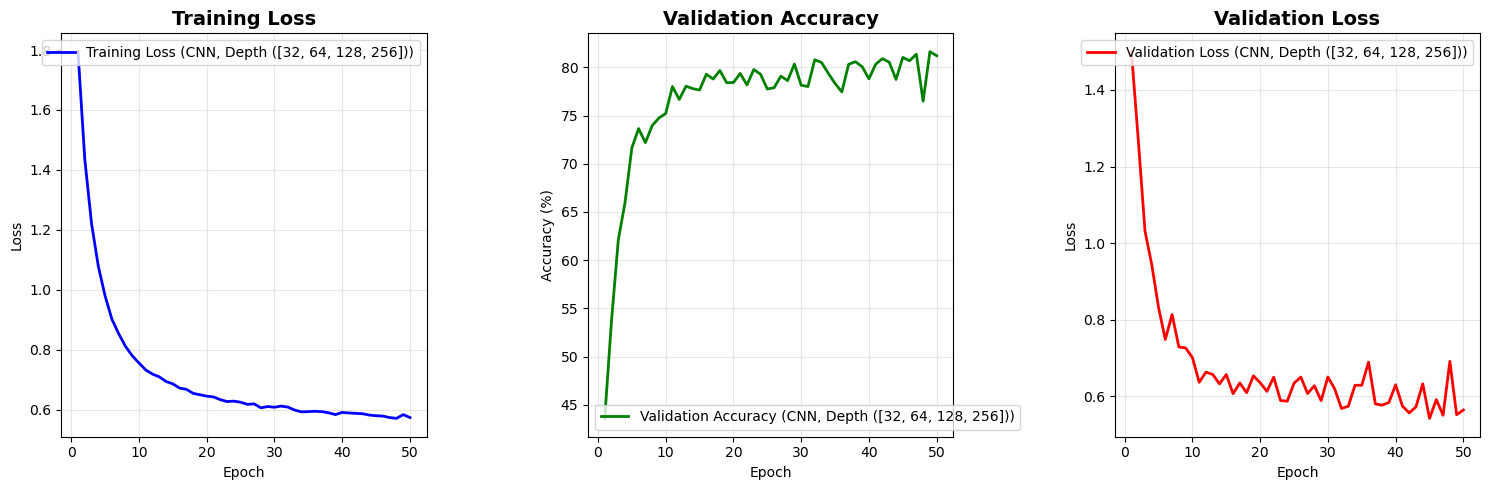

Test Accuracy: 81.40%

Classification Report:
              precision    recall  f1-score   support

           0      0.761     0.884     0.818      1000
           1      0.928     0.888     0.908      1000
           2      0.737     0.741     0.739      1000
           3      0.757     0.604     0.672      1000
           4      0.746     0.870     0.803      1000
           5      0.747     0.764     0.755      1000
           6      0.862     0.839     0.850      1000
           7      0.890     0.833     0.861      1000
           8      0.811     0.915     0.860      1000
           9      0.942     0.802     0.867      1000

    accuracy                          0.814     10000
   macro avg      0.818     0.814     0.813     10000
weighted avg      0.818     0.814     0.813     10000



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_acc,▁▃▄▅▆▇▇▇▇▇▇▇▇███████████████████████████
best_val_loss,█▆▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▂▁▁▁▂▁▂▁▂▃▄▅▆▁▁▃▄▅▆▆▂▃▃▄▅▆▇█▁▂▁▂▃▃▅
test_accuracy,▁
train_loss,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▆▆▆▇▇▇▇▇▇▇██▇▇▇█▇█▇▇▇███▇▇██████████
val_loss,██▅▄▃▂▂▂▂▂▂▁▁▂▁▂▂▂▂▁▂▂▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▂▂▁
best_val_acc,81.04
best_val_loss,0.54269


Epoch   1: Train Loss: 1.7608, Val Loss: 1.4372, Val Acc: 46.34% NEW BEST
Epoch   2: Train Loss: 1.2933, Val Loss: 1.0395, Val Acc: 63.44% NEW BEST
Epoch   3: Train Loss: 1.0504, Val Loss: 0.8434, Val Acc: 69.78% NEW BEST
Epoch   4: Train Loss: 0.8955, Val Loss: 0.8366, Val Acc: 70.18% NEW BEST
Epoch   5: Train Loss: 0.7983, Val Loss: 0.7074, Val Acc: 75.78% NEW BEST
Epoch   6: Train Loss: 0.7358, Val Loss: 0.6629, Val Acc: 77.82% NEW BEST
Epoch   7: Train Loss: 0.6892, Val Loss: 0.7098, Val Acc: 75.76% (1/10)
Epoch   8: Train Loss: 0.6472, Val Loss: 0.5908, Val Acc: 79.66% NEW BEST
Epoch   9: Train Loss: 0.6125, Val Loss: 0.6303, Val Acc: 78.50% (1/10)
Epoch  10: Train Loss: 0.6012, Val Loss: 0.6146, Val Acc: 79.02% (2/10)
Epoch  11: Train Loss: 0.5665, Val Loss: 0.5871, Val Acc: 79.68% NEW BEST
Epoch  12: Train Loss: 0.5590, Val Loss: 0.6604, Val Acc: 77.92% (1/10)
Epoch  13: Train Loss: 0.5392, Val Loss: 0.5764, Val Acc: 79.70% NEW BEST
Epoch  14: Train Loss: 0.5267, Val Loss: 0.655

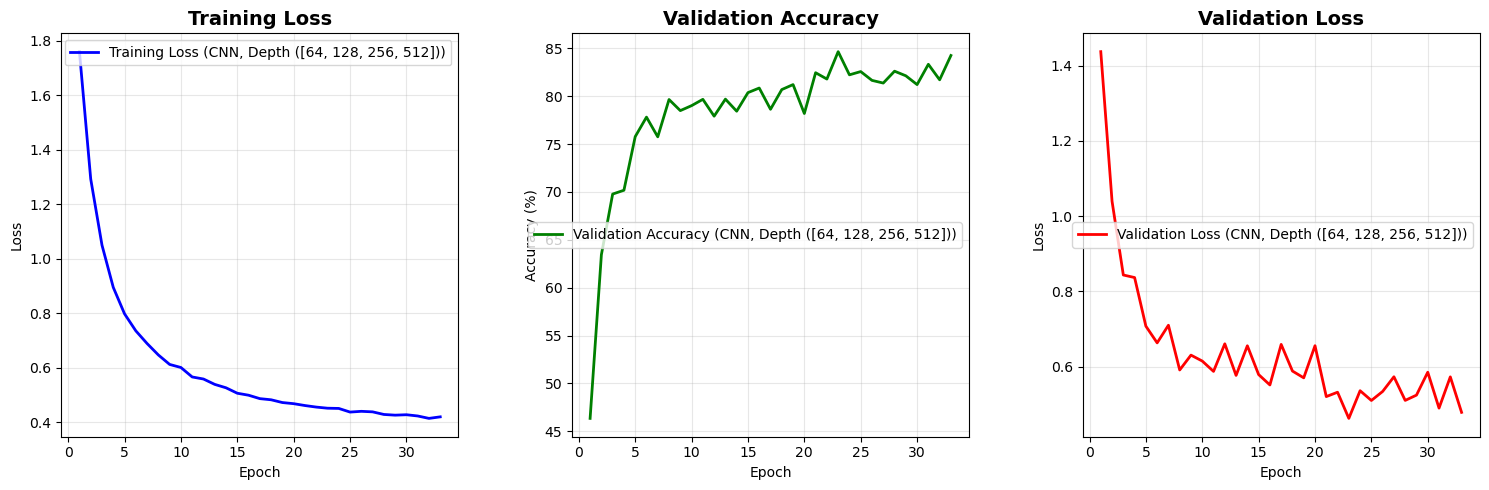

Test Accuracy: 84.36%

Classification Report:
              precision    recall  f1-score   support

           0      0.823     0.890     0.855      1000
           1      0.887     0.939     0.912      1000
           2      0.776     0.774     0.775      1000
           3      0.809     0.630     0.708      1000
           4      0.835     0.834     0.834      1000
           5      0.768     0.803     0.785      1000
           6      0.824     0.931     0.874      1000
           7      0.867     0.890     0.879      1000
           8      0.935     0.881     0.907      1000
           9      0.919     0.864     0.891      1000

    accuracy                          0.844     10000
   macro avg      0.844     0.844     0.842     10000
weighted avg      0.844     0.844     0.842     10000



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_acc,▁▄▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
best_val_loss,█▅▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▁▂▁▂▂▁▂▁▂▂▁▂▂▃▄▁▂▁▂▂▃▄▅▅▆▇▇█
test_accuracy,▁
train_loss,█▆▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▄▄▅▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████▇▇███▇██▇█
val_loss,█▆▆▆▆▃▄▄▃▃▃▃▃▃▂▃▂▂▂▃▃▂▂▃▃▂▂▁▂▂▂▂▂▂▂▂▁▁▂▁
best_val_acc,84.66
best_val_loss,0.46211


Epoch   1: Train Loss: 1.7188, Val Loss: 1.3988, Val Acc: 49.04% NEW BEST
Epoch   2: Train Loss: 1.3164, Val Loss: 1.1339, Val Acc: 58.76% NEW BEST
Epoch   3: Train Loss: 1.0969, Val Loss: 0.9248, Val Acc: 67.18% NEW BEST
Epoch   4: Train Loss: 0.9566, Val Loss: 0.8548, Val Acc: 69.98% NEW BEST
Epoch   5: Train Loss: 0.8573, Val Loss: 0.7593, Val Acc: 73.76% NEW BEST
Epoch   6: Train Loss: 0.7865, Val Loss: 0.7482, Val Acc: 74.74% NEW BEST
Epoch   7: Train Loss: 0.7380, Val Loss: 0.6457, Val Acc: 78.06% NEW BEST
Epoch   8: Train Loss: 0.6976, Val Loss: 0.6098, Val Acc: 78.82% NEW BEST
Epoch   9: Train Loss: 0.6642, Val Loss: 0.7003, Val Acc: 75.60% (1/10)
Epoch  10: Train Loss: 0.6423, Val Loss: 0.6137, Val Acc: 78.42% (2/10)
Epoch  11: Train Loss: 0.6130, Val Loss: 0.6249, Val Acc: 79.22% (3/10)
Epoch  12: Train Loss: 0.5994, Val Loss: 0.6433, Val Acc: 78.92% (4/10)
Epoch  13: Train Loss: 0.5826, Val Loss: 0.6904, Val Acc: 77.60% (5/10)
Epoch  14: Train Loss: 0.5672, Val Loss: 0.6152,

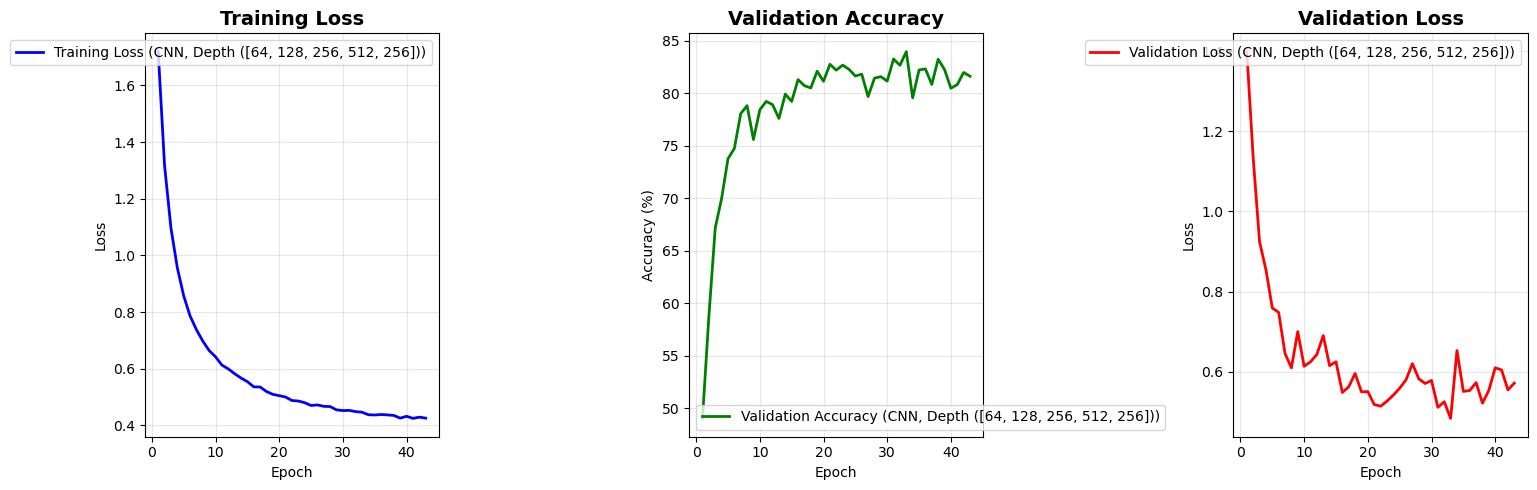

Test Accuracy: 84.11%

Classification Report:
              precision    recall  f1-score   support

           0      0.827     0.871     0.849      1000
           1      0.958     0.865     0.909      1000
           2      0.795     0.776     0.785      1000
           3      0.712     0.713     0.713      1000
           4      0.810     0.877     0.842      1000
           5      0.773     0.793     0.783      1000
           6      0.837     0.898     0.866      1000
           7      0.893     0.874     0.883      1000
           8      0.954     0.842     0.894      1000
           9      0.882     0.902     0.892      1000

    accuracy                          0.841     10000
   macro avg      0.844     0.841     0.842     10000
weighted avg      0.844     0.841     0.842     10000



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_acc,▁▃▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
best_val_loss,█▆▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▁▁▁▂▂▃▄▅▆▁▂▂▃▄▁▁▂▂▃▄▅▆▇▁▂▁▂▂▃▄▅▅▆▇█
test_accuracy,▁
train_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▄▅▇▇▆▆▇▆▆▇▇▇▇▇▇▇███▇▇▇▇███▇████▇███▇▇
val_loss,██▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▂▂▂▁▁▂▂▂▂▁▁▂▂▂▂▂
best_val_acc,83.96
best_val_loss,0.48375


In [ ]:
#train a CNN with different depths
depth_configs = {
    'shallow': [32, 64],
    'medium': [32, 64, 128], 
    'deep': [32, 64, 128, 256],
    'very_deep': [64, 128, 256, 512],
    'ultra_deep': [64, 128, 256, 512, 256]
}

for depth_name, hidden_channels in depth_configs.items():
    model_CNN = My_Configurable_CNN(input_size, input_channels, hidden_channels, num_classes).to(device)
    lr = 0.1
    optimizer = torch.optim.SGD(model_CNN.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, step_size=30, gamma=0.1)
    name_run = f"lab1_esercizio1.3 - {depth_name} CNN "
    run = wandb.init(
        project="DLALabs",
        name=name_run,
        config={
            "model": "CNN",
            "epochs": 50,
            "learning_rate": 0.1,
            "batch_size": 128,
            "input_size": 32*32,
            "input_channels": input_channels,
            "hidden_channels": hidden_channels,
            "num_classes": 10,
            "optimizer": "SGD",
            "loss_function": "CrossEntropyLoss"
        }
    )
    run.watch(model_CNN, log="gradients", log_freq=50)
    train_losses, val_accuracies, val_losses = train(model_CNN, dl_train, dl_val, epochs, criterion, optimizer, device, scheduler=scheduler)
    print("CNN")
    plot_training_metrics(train_losses=train_losses,val_accuracies=val_accuracies, val_losses=val_losses, save_path=f"plot/CNN({depth_name})", model_name="CNN", model_depth=hidden_channels)
    (accuracy, _, report) = evaluate(model_CNN, dl_test, device, log_wandb=True)

    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'\nClassification Report:\n{report}')

    model_path = f"model_CNN_{depth_name}.pth"
    torch.save({
        'model_state_dict': model_CNN.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': accuracy,
        'hidden_channels': hidden_channels,
    }, model_path)

    artifact = wandb.Artifact(
        name=f"model_CNN_{depth_name}", 
        type="model",
        description=f"CNN model with {hidden_channels} depth"
    )
    artifact.add_file(model_path)
    wandb.log_artifact(artifact)
    wandb.finish()








Epoch   1: Train Loss: 1.6497, Val Loss: 1.5434, Val Acc: 44.46% NEW BEST
Epoch   2: Train Loss: 1.3365, Val Loss: 1.3510, Val Acc: 49.10% NEW BEST
Epoch   3: Train Loss: 1.2091, Val Loss: 1.2494, Val Acc: 53.98% NEW BEST
Epoch   4: Train Loss: 1.1328, Val Loss: 1.1466, Val Acc: 59.14% NEW BEST
Epoch   5: Train Loss: 1.0785, Val Loss: 1.2039, Val Acc: 57.10% (1/20)
Epoch   6: Train Loss: 1.0483, Val Loss: 1.1672, Val Acc: 56.70% (2/20)
Epoch   7: Train Loss: 1.0174, Val Loss: 1.1114, Val Acc: 60.54% NEW BEST
Epoch   8: Train Loss: 0.9938, Val Loss: 1.1611, Val Acc: 57.56% (1/20)
Epoch   9: Train Loss: 0.9782, Val Loss: 1.1799, Val Acc: 57.68% (2/20)
Epoch  10: Train Loss: 0.9684, Val Loss: 1.2138, Val Acc: 57.56% (3/20)
Epoch  11: Train Loss: 0.9564, Val Loss: 1.0655, Val Acc: 62.86% NEW BEST
Epoch  12: Train Loss: 0.9404, Val Loss: 0.8871, Val Acc: 68.92% NEW BEST
Epoch  13: Train Loss: 0.9369, Val Loss: 1.0296, Val Acc: 65.02% (1/20)
Epoch  14: Train Loss: 0.9201, Val Loss: 1.4012, V

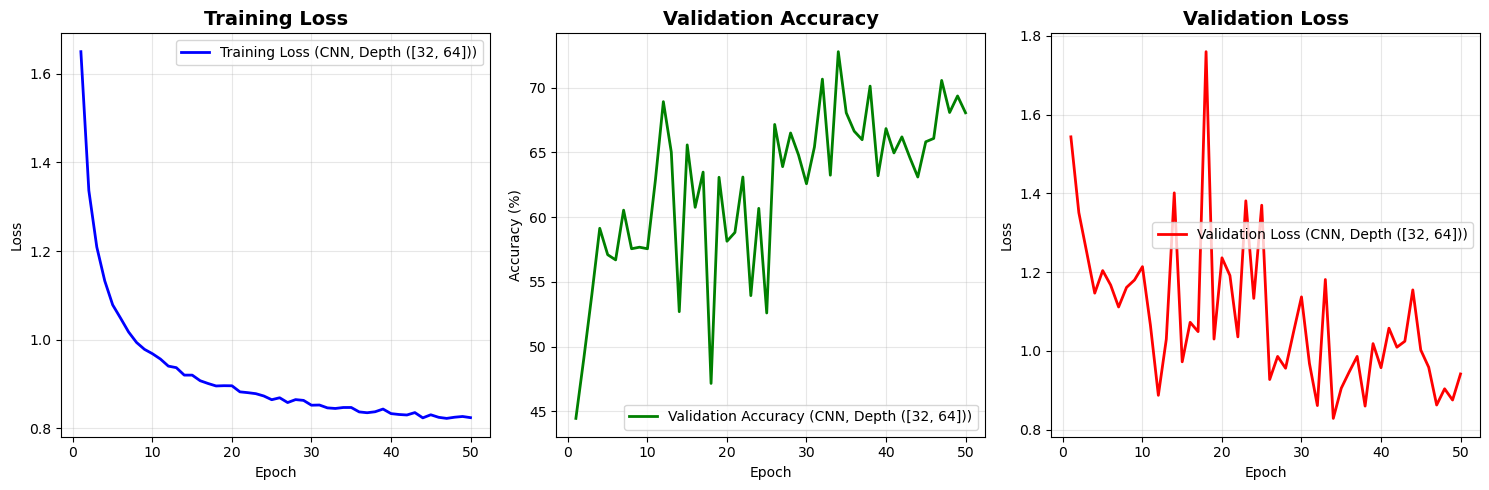

Test Accuracy: 71.03%

Classification Report:
              precision    recall  f1-score   support

           0      0.712     0.664     0.687      1000
           1      0.785     0.911     0.843      1000
           2      0.630     0.561     0.594      1000
           3      0.559     0.494     0.524      1000
           4      0.747     0.591     0.660      1000
           5      0.697     0.606     0.648      1000
           6      0.706     0.782     0.742      1000
           7      0.760     0.757     0.759      1000
           8      0.671     0.938     0.782      1000
           9      0.824     0.799     0.811      1000

    accuracy                          0.710     10000
   macro avg      0.709     0.710     0.705     10000
weighted avg      0.709     0.710     0.705     10000



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_acc,▁▂▃▅▅▅▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
best_val_loss,█▆▅▄▄▄▄▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▁▁▂▂▁▁▂▂▂▃▄▄▅▅▅▇▇▇██▁▁▁▂▂▃▃▄▄▄▅▅▆▆▇
test_accuracy,▁
train_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▅▄▄▄▅▄▄▆▆▆▆▅▂▄▆▃▅▇▆▆▅▆█▇▇▆▆▇▆▆▆▆▆▇▇▇▇
val_loss,▆▅▄▄▄▃▃▄▃▃▅▂██▂▄▂▅▃▂▂▃▂▁▁▂▂▁▂▂▃▂▂▂▃▁▁▁▁▂
best_val_acc,72.78
best_val_loss,0.82855


Epoch   1: Train Loss: 1.5211, Val Loss: 1.2791, Val Acc: 53.24% NEW BEST
Epoch   2: Train Loss: 1.1059, Val Loss: 1.1943, Val Acc: 55.08% NEW BEST
Epoch   3: Train Loss: 0.9398, Val Loss: 0.9782, Val Acc: 65.08% NEW BEST
Epoch   4: Train Loss: 0.8246, Val Loss: 0.8704, Val Acc: 69.38% NEW BEST
Epoch   5: Train Loss: 0.7419, Val Loss: 0.9215, Val Acc: 67.42% (1/20)
Epoch   6: Train Loss: 0.7016, Val Loss: 0.8140, Val Acc: 72.86% NEW BEST
Epoch   7: Train Loss: 0.6511, Val Loss: 0.9631, Val Acc: 68.30% (1/20)
Epoch   8: Train Loss: 0.6291, Val Loss: 0.7340, Val Acc: 75.18% NEW BEST
Epoch   9: Train Loss: 0.5949, Val Loss: 0.7632, Val Acc: 73.36% (1/20)
Epoch  10: Train Loss: 0.5793, Val Loss: 0.7834, Val Acc: 73.16% (2/20)
Epoch  11: Train Loss: 0.5594, Val Loss: 0.6738, Val Acc: 76.86% NEW BEST
Epoch  12: Train Loss: 0.5429, Val Loss: 0.7132, Val Acc: 75.44% (1/20)
Epoch  13: Train Loss: 0.5305, Val Loss: 0.7477, Val Acc: 75.46% (2/20)
Epoch  14: Train Loss: 0.5198, Val Loss: 0.8554, V

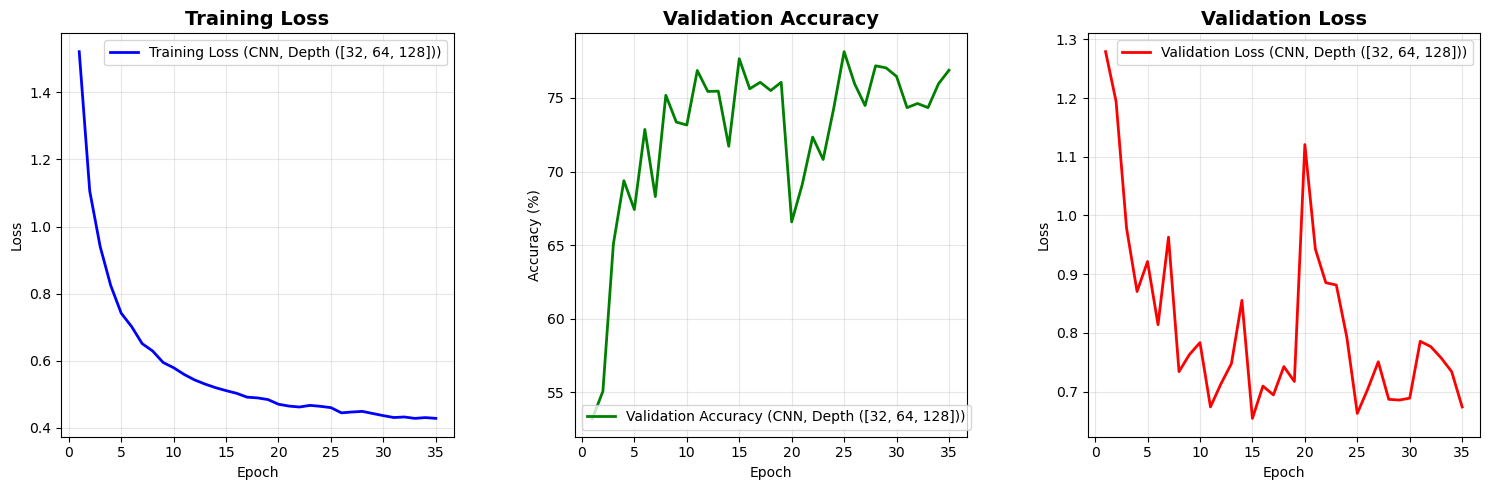

Test Accuracy: 77.71%

Classification Report:
              precision    recall  f1-score   support

           0      0.762     0.861     0.808      1000
           1      0.962     0.789     0.867      1000
           2      0.697     0.693     0.695      1000
           3      0.584     0.649     0.615      1000
           4      0.742     0.821     0.779      1000
           5      0.794     0.528     0.634      1000
           6      0.765     0.881     0.819      1000
           7      0.937     0.711     0.808      1000
           8      0.831     0.921     0.874      1000
           9      0.794     0.917     0.851      1000

    accuracy                          0.777     10000
   macro avg      0.787     0.777     0.775     10000
weighted avg      0.787     0.777     0.775     10000



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_acc,▁▂▄▆▆▇▇▇▇▇█████████████████████████
best_val_loss,█▇▅▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▁▁▁▁▂▁▁▂▂▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
test_accuracy,▁
train_loss,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▄▅▅▅▇▅▇▇▇█▇▇▇███▇█▅▅▆▆▆▇▇▇▇████▇▇▇▇▇▇█
val_loss,██▇▅▅▄▄▃▃▄▂▂▂▁▂▂▂▃▃▁▂▁▁▂▆▄▄▄▄▄▁▁▂▂▂▁▁▂▂▂
best_val_acc,77.66
best_val_loss,0.65425


Epoch   1: Train Loss: 1.4979, Val Loss: 1.1990, Val Acc: 57.02% NEW BEST
Epoch   2: Train Loss: 1.0684, Val Loss: 1.0980, Val Acc: 61.82% NEW BEST
Epoch   3: Train Loss: 0.8818, Val Loss: 0.9121, Val Acc: 68.42% NEW BEST
Epoch   4: Train Loss: 0.7528, Val Loss: 0.9269, Val Acc: 68.06% (1/20)
Epoch   5: Train Loss: 0.6767, Val Loss: 0.7377, Val Acc: 74.88% NEW BEST
Epoch   6: Train Loss: 0.6199, Val Loss: 0.7484, Val Acc: 74.42% (1/20)
Epoch   7: Train Loss: 0.5709, Val Loss: 0.8041, Val Acc: 73.88% (2/20)
Epoch   8: Train Loss: 0.5380, Val Loss: 0.9196, Val Acc: 69.92% (3/20)
Epoch   9: Train Loss: 0.5015, Val Loss: 0.7719, Val Acc: 74.38% (4/20)
Epoch  10: Train Loss: 0.4846, Val Loss: 0.9206, Val Acc: 70.88% (5/20)
Epoch  11: Train Loss: 0.4629, Val Loss: 0.7232, Val Acc: 76.44% NEW BEST
Epoch  12: Train Loss: 0.4380, Val Loss: 0.8292, Val Acc: 73.50% (1/20)
Epoch  13: Train Loss: 0.4296, Val Loss: 0.7603, Val Acc: 74.74% (2/20)
Epoch  14: Train Loss: 0.4044, Val Loss: 0.8988, Val A

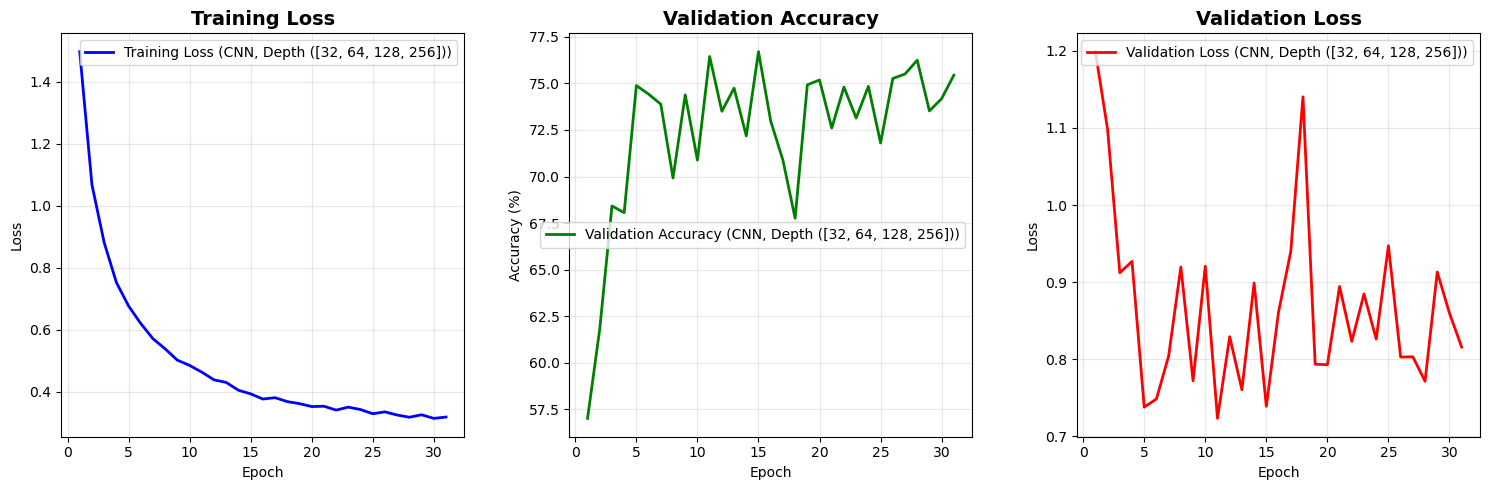

Test Accuracy: 75.79%

Classification Report:
              precision    recall  f1-score   support

           0      0.827     0.728     0.774      1000
           1      0.824     0.916     0.868      1000
           2      0.673     0.674     0.674      1000
           3      0.556     0.641     0.596      1000
           4      0.772     0.682     0.724      1000
           5      0.639     0.702     0.669      1000
           6      0.820     0.771     0.795      1000
           7      0.823     0.793     0.808      1000
           8      0.839     0.855     0.847      1000
           9      0.859     0.817     0.838      1000

    accuracy                          0.758     10000
   macro avg      0.763     0.758     0.759     10000
weighted avg      0.763     0.758     0.759     10000



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_acc,▁▃▅▅▇▇▇▇▇▇█████████████████████
best_val_loss,█▇▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▁▂▂▂▃▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
test_accuracy,▁
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▅▅▅▇▇▇▇▆▇▆▆██▇▇▆█▇▅▅▇▇▇▇▇▇▇▇▆▇███▇▇▇▇█
val_loss,█▇▇▄▁▁▂▄▄▂▄▁▃▃▂▄▁▁▃▃▄▇▂▂▂▄▂▂▃▃▄▄▂▂▂▂▄▄▃▂
best_val_acc,76.44
best_val_loss,0.72318


Epoch   1: Train Loss: 1.4688, Val Loss: 1.1805, Val Acc: 57.56% NEW BEST
Epoch   2: Train Loss: 1.0270, Val Loss: 0.9539, Val Acc: 66.14% NEW BEST
Epoch   3: Train Loss: 0.8295, Val Loss: 0.9149, Val Acc: 67.80% NEW BEST
Epoch   4: Train Loss: 0.6915, Val Loss: 0.7463, Val Acc: 74.44% NEW BEST
Epoch   5: Train Loss: 0.5968, Val Loss: 0.7355, Val Acc: 74.28% NEW BEST
Epoch   6: Train Loss: 0.5286, Val Loss: 0.7841, Val Acc: 73.16% (1/20)
Epoch   7: Train Loss: 0.4689, Val Loss: 0.7519, Val Acc: 74.92% (2/20)
Epoch   8: Train Loss: 0.4338, Val Loss: 0.8117, Val Acc: 71.82% (3/20)
Epoch   9: Train Loss: 0.3951, Val Loss: 0.7444, Val Acc: 75.82% (4/20)
Epoch  10: Train Loss: 0.3636, Val Loss: 0.8579, Val Acc: 73.10% (5/20)
Epoch  11: Train Loss: 0.3447, Val Loss: 0.7207, Val Acc: 76.02% NEW BEST
Epoch  12: Train Loss: 0.3143, Val Loss: 0.8939, Val Acc: 73.86% (1/20)
Epoch  13: Train Loss: 0.3091, Val Loss: 0.8127, Val Acc: 74.38% (2/20)
Epoch  14: Train Loss: 0.2994, Val Loss: 0.9154, Val

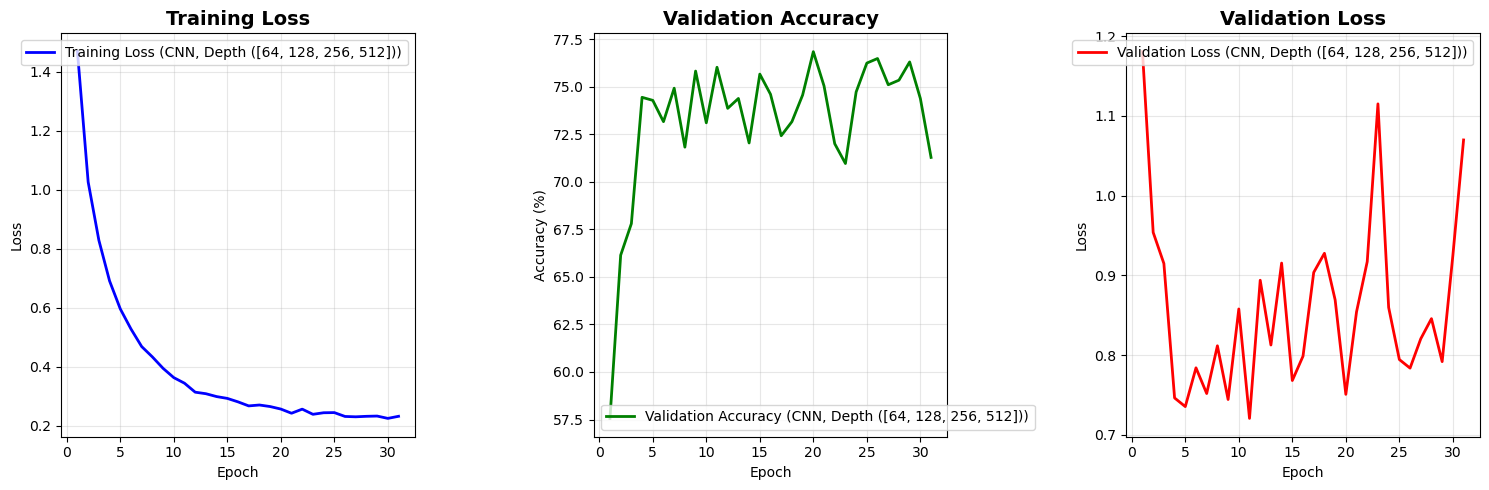

Test Accuracy: 75.94%

Classification Report:
              precision    recall  f1-score   support

           0      0.815     0.772     0.793      1000
           1      0.861     0.886     0.873      1000
           2      0.686     0.663     0.674      1000
           3      0.606     0.604     0.605      1000
           4      0.646     0.822     0.724      1000
           5      0.672     0.717     0.694      1000
           6      0.861     0.754     0.804      1000
           7      0.913     0.658     0.765      1000
           8      0.781     0.901     0.837      1000
           9      0.841     0.817     0.829      1000

    accuracy                          0.759     10000
   macro avg      0.768     0.759     0.760     10000
weighted avg      0.768     0.759     0.760     10000



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_acc,▁▄▅▇▇▇▇▇▇▇█████████████████████
best_val_loss,█▅▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▁▂▂▂▃▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
test_accuracy,▁
train_loss,█▆▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▅▅▇▇▇▇▇▆▆▇▇█▇▇▇▆▆▇▇▆▇▇▇█▇▇▇███▇▇▇██▇▆
val_loss,█▄▄▄▁▁▂▂▁▁▂▁▁▃▃▃▃▂▄▄▂▂▄▄▄▃▁▁▃▄▇▃▂▂▂▃▂▄▄▆
best_val_acc,76.02
best_val_loss,0.7207


Epoch   1: Train Loss: 2.1175, Val Loss: 1.5582, Val Acc: 41.46% NEW BEST
Epoch   2: Train Loss: 1.3840, Val Loss: 1.3833, Val Acc: 48.60% NEW BEST
Epoch   3: Train Loss: 1.1543, Val Loss: 1.4073, Val Acc: 51.72% (1/20)
Epoch   4: Train Loss: 0.9527, Val Loss: 1.1193, Val Acc: 61.30% NEW BEST
Epoch   5: Train Loss: 0.8104, Val Loss: 0.8976, Val Acc: 68.28% NEW BEST
Epoch   6: Train Loss: 0.7001, Val Loss: 0.8259, Val Acc: 71.08% NEW BEST
Epoch   7: Train Loss: 0.6092, Val Loss: 0.7933, Val Acc: 72.76% NEW BEST
Epoch   8: Train Loss: 0.5578, Val Loss: 0.8753, Val Acc: 71.92% (1/20)
Epoch   9: Train Loss: 0.5145, Val Loss: 0.8103, Val Acc: 72.66% (2/20)
Epoch  10: Train Loss: 0.4706, Val Loss: 0.7617, Val Acc: 74.90% NEW BEST
Epoch  11: Train Loss: 0.4369, Val Loss: 0.7881, Val Acc: 74.22% (1/20)
Epoch  12: Train Loss: 0.4048, Val Loss: 0.8296, Val Acc: 73.78% (2/20)
Epoch  13: Train Loss: 0.3849, Val Loss: 0.8163, Val Acc: 74.46% (3/20)
Epoch  14: Train Loss: 0.3672, Val Loss: 1.0129, V

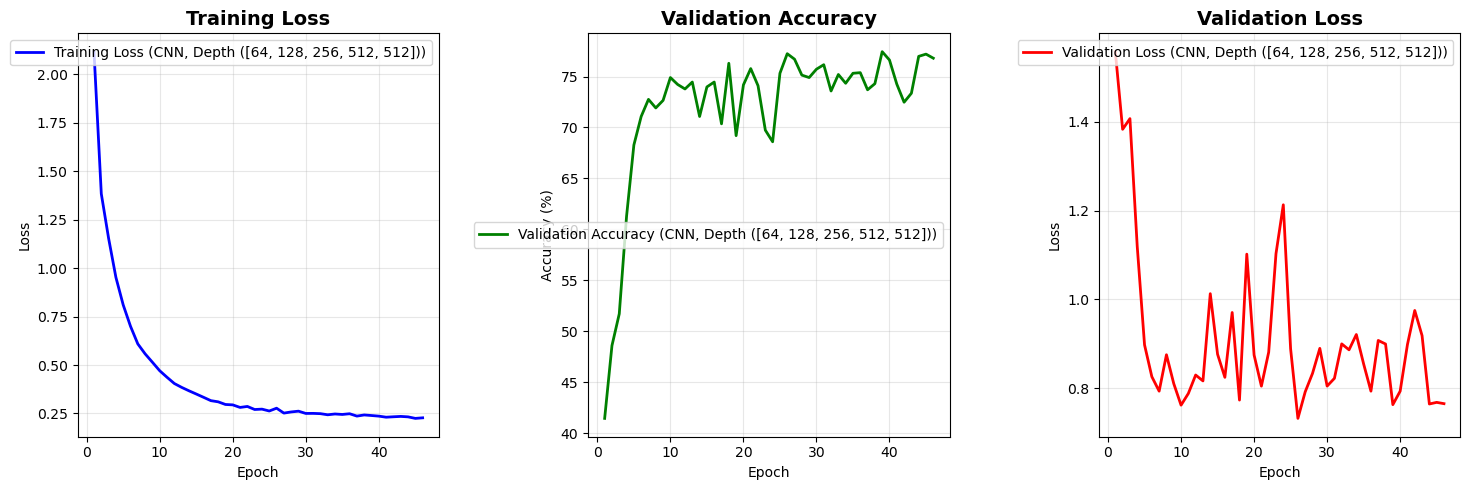

Test Accuracy: 76.17%

Classification Report:
              precision    recall  f1-score   support

           0      0.793     0.799     0.796      1000
           1      0.903     0.829     0.864      1000
           2      0.711     0.645     0.676      1000
           3      0.542     0.694     0.609      1000
           4      0.749     0.710     0.729      1000
           5      0.763     0.570     0.653      1000
           6      0.889     0.739     0.807      1000
           7      0.715     0.870     0.785      1000
           8      0.848     0.890     0.869      1000
           9      0.795     0.871     0.831      1000

    accuracy                          0.762     10000
   macro avg      0.771     0.762     0.762     10000
weighted avg      0.771     0.762     0.762     10000



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_acc,▁▂▂▅▆▇▇▇████████████████████████████████
best_val_loss,█▇▇▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▁▁▂▁▁▂▂▂▃▄▄▄▅▅▅▆▇▁▁▂▂▂▃▄▄▄▅▅▆▆▇▇▇██
test_accuracy,▁
train_loss,█▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▅▆▇▇▇▇█▇▇▇▇▇▆▇▇▇▇████████████▇██▇████
val_loss,█▆▄▂▂▁▁▁▁▂▁▂▂▃▄▂▁▂▂▄▅▂▁▂▁▂▂▂▂▂▂▂▂▁▁▂▃▂▁▁
best_val_acc,77.24
best_val_loss,0.73189


Epoch   1: Train Loss: 1.9133, Val Loss: 1.5490, Val Acc: 42.24% NEW BEST
Epoch   2: Train Loss: 1.3930, Val Loss: 1.4064, Val Acc: 48.46% NEW BEST
Epoch   3: Train Loss: 1.1830, Val Loss: 1.2302, Val Acc: 56.72% NEW BEST
Epoch   4: Train Loss: 1.0070, Val Loss: 1.0657, Val Acc: 61.42% NEW BEST
Epoch   5: Train Loss: 0.8893, Val Loss: 1.0498, Val Acc: 63.40% NEW BEST
Epoch   6: Train Loss: 0.7797, Val Loss: 0.9936, Val Acc: 65.60% NEW BEST
Epoch   7: Train Loss: 0.6991, Val Loss: 0.8398, Val Acc: 71.28% NEW BEST
Epoch   8: Train Loss: 0.6269, Val Loss: 0.8340, Val Acc: 71.14% NEW BEST
Epoch   9: Train Loss: 0.5713, Val Loss: 0.8091, Val Acc: 72.66% NEW BEST
Epoch  10: Train Loss: 0.5224, Val Loss: 0.9381, Val Acc: 70.28% (1/20)
Epoch  11: Train Loss: 0.4824, Val Loss: 0.8552, Val Acc: 71.92% (2/20)
Epoch  12: Train Loss: 0.4504, Val Loss: 0.7709, Val Acc: 74.32% NEW BEST
Epoch  13: Train Loss: 0.4245, Val Loss: 0.7742, Val Acc: 74.80% (1/20)
Epoch  14: Train Loss: 0.4023, Val Loss: 0.8

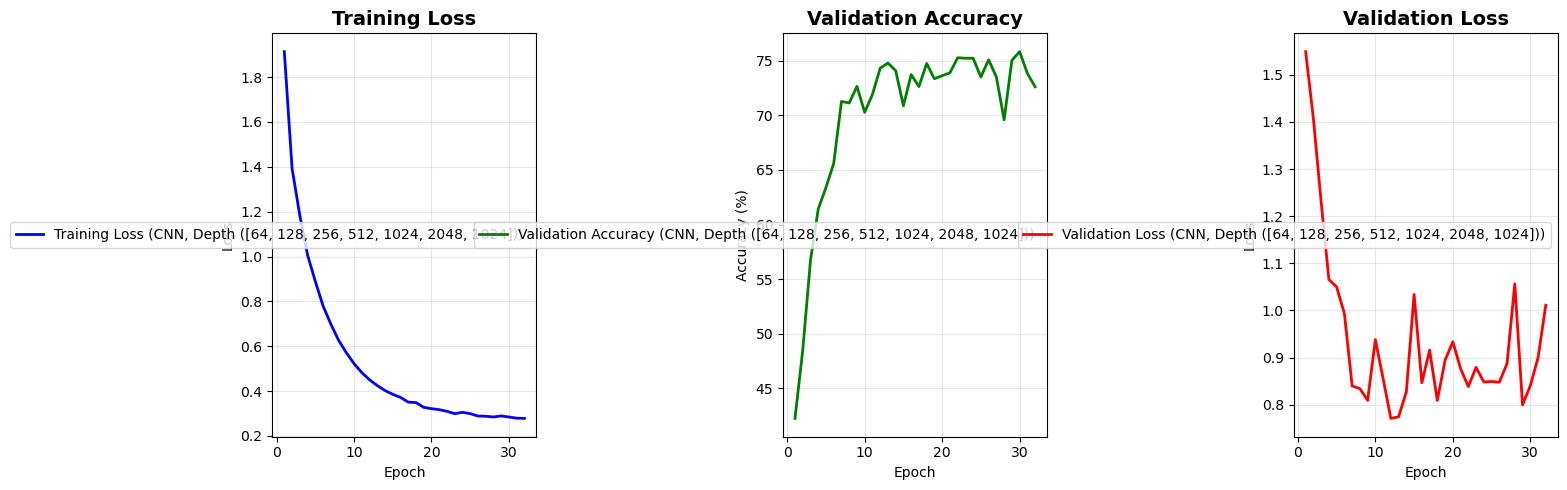

Test Accuracy: 73.77%

Classification Report:
              precision    recall  f1-score   support

           0      0.760     0.793     0.776      1000
           1      0.933     0.776     0.847      1000
           2      0.649     0.649     0.649      1000
           3      0.493     0.641     0.558      1000
           4      0.825     0.596     0.692      1000
           5      0.675     0.573     0.620      1000
           6      0.762     0.865     0.810      1000
           7      0.786     0.790     0.788      1000
           8      0.757     0.890     0.818      1000
           9      0.857     0.804     0.830      1000

    accuracy                          0.738     10000
   macro avg      0.750     0.738     0.739     10000
weighted avg      0.750     0.738     0.739     10000



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_acc,▁▂▄▅▆▆▇▇████████████████████████
best_val_loss,█▇▅▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
patience_counter,▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
test_accuracy,▁
train_loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▄▄▅▅▅▆▆▇▇▇▇▇████▇▇▇█████████████████▇
val_loss,██▇▅▅▄▄▃▃▂▂▁▁▃▂▁▁▁▂▃▂▂▁▂▂▂▂▂▂▂▂▂▂▄▁▂▂▂▂▃
best_val_acc,74.32
best_val_loss,0.77091


In [ ]:
#train a Residual CNN with different depths
depth_configs = {
    'light': [32, 64],              
    'shallow': [32, 64, 128],         
    'medium': [32, 64, 128, 256],   
    'deep': [64, 128, 256, 512],    
    'very_deep': [64, 128, 256, 512, 512],
    'extremely_deep':  [64, 128, 256, 512, 1024, 2048, 1024]
}

for depth_name, hidden_channels in depth_configs.items():
    model_Residual_CNN = My_Residual_CNN(input_size, input_channels, hidden_channels, num_classes).to(device)
    lr = 0.1
    optimizer = torch.optim.SGD(model_Residual_CNN.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, step_size=30, gamma=0.1)
    name_run = f"lab1_esercizio1.3 - {depth_name} Residual CNN "
    run = wandb.init(
        project="DLALabs",
        name=name_run,
        config={
            "model": "Residual CNN",
            "epochs": 50,
            "learning_rate": 0.1,
            "batch_size": 128,
            "input_size": 32*32,
            "input_channels": input_channels,
            "hidden_channels": hidden_channels,
            "num_classes": 10,
            "optimizer": "SGD",
            "loss_function": "CrossEntropyLoss"
        }
    )
    run.watch(model_Residual_CNN, log="gradients", log_freq=50)
    train_losses, val_accuracies, val_losses = train(model_Residual_CNN, dl_train, dl_val, epochs, criterion, optimizer, device, scheduler=scheduler)
    print("Residual CNN")
    plot_training_metrics(train_losses=train_losses,val_accuracies=val_accuracies, val_losses=val_losses, save_path=f"plot/Residual_CNN_{depth_name}", model_name="CNN", model_depth=hidden_channels)
    (accuracy, _, report) = evaluate(model_Residual_CNN, dl_test, device, log_wandb=True)

    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'\nClassification Report:\n{report}')

    model_path = f"model_Residual_CNN_{depth_name}.pth"
    torch.save({
        'model_state_dict': model_Residual_CNN.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': accuracy,
        'hidden_channels': hidden_channels,
    }, model_path)

    artifact = wandb.Artifact(
        name=f"model_Residual_CNN_{depth_name}", 
        type="model",
        description=f"Residual CNN model with {hidden_channels} depth"
    )
    artifact.add_file(model_path)
    wandb.log_artifact(artifact)

    wandb.finish()








-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit. Each exercise is designed to require you to dig your hands **deep** into the guts of your models in order to do new and interesting things.

**Note**: These exercises are designed to use your small, custom CNNs and small datasets. This is to keep training times reasonable. If you have a decent GPU, feel free to use pretrained ResNets and larger datasets (e.g. the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset at 160px).

### Exercise 2.1: *Fine-tune* a pre-trained model
Train one of your residual CNN models from Exercise 1.3 on CIFAR-10. Then:
1. Use the pre-trained model as a **feature extractor** (i.e. to extract the feature activations of the layer input into the classifier) on CIFAR-100. Use a **classical** approach (e.g. Linear SVM, K-Nearest Neighbor, or Bayesian Generative Classifier) from scikit-learn to establish a **stable baseline** performance on CIFAR-100 using the features extracted using your CNN.
2. Fine-tune your CNN on the CIFAR-100 training set and compare with your stable baseline. Experiment with different strategies:
    - Unfreeze some of the earlier layers for fine-tuning.
    - Test different optimizers (Adam, SGD, etc.).

Each of these steps will require you to modify your model definition in some way. For 1, you will need to return the activations of the last fully-connected layer (or the global average pooling layer). For 2, you will need to replace the original, 10-class classifier with a new, randomly-initialized 100-class classifier.

In [15]:
# Your code here.

### Exercise 2.2: *Distill* the knowledge from a large model into a smaller one
In this exercise you will see if you can derive a *small* model that performs comparably to a larger one on CIFAR-10. To do this, you will use [Knowledge Distillation](https://arxiv.org/abs/1503.02531):

> Geoffrey Hinton, Oriol Vinyals, and Jeff Dean. Distilling the Knowledge in a Neural Network, NeurIPS 2015.

To do this:
1. Train one of your best-performing CNNs on CIFAR-10 from Exercise 1.3 above. This will be your **teacher** model.
2. Define a *smaller* variant with about half the number of parameters (change the width and/or depth of the network). Train it on CIFAR-10 and verify that it performs *worse* than your **teacher**. This small network will be your **student** model.
3. Train the **student** using a combination of **hard labels** from the CIFAR-10 training set (cross entropy loss) and **soft labels** from predictions of the **teacher** (Kulback-Leibler loss between teacher and student).

Try to optimize training parameters in order to maximize the performance of the student. It should at least outperform the student trained only on hard labels in Setp 2.

**Tip**: You can save the predictions of the trained teacher network on the training set and adapt your dataloader to provide them together with hard labels. This will **greatly** speed up training compared to performing a forward pass through the teacher for each batch of training.

In [16]:
# Your code here.

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.3 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your CNN implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes. Try your implementation out using a pre-trained ResNet-18 model and some images from the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset -- I suggest you start with the low resolution version of images at 160px.

In [17]:
def cam_results(image, cam, predicted_class, true_label, confidence, dataset_classes):

    # Data preparation
    img_np = image[0].cpu().permute(1, 2, 0).numpy()
    cam_np = cam[0, 0].cpu().detach().numpy()
    
    # Normalization if needed
    if img_np.min() < 0:  # if normalized [-1,1] or similar
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img_np)
    axes[0].set_title(f'Original Image\nTrue: {dataset_classes[true_label]}', fontsize=12)
    axes[0].axis('off')
    
    im = axes[1].imshow(cam_np, cmap='jet')
    axes[1].set_title(f'Class Activation Map\nPred: {dataset_classes[predicted_class]}', fontsize=12)
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046)
    
    axes[2].imshow(img_np)
    axes[2].imshow(cam_np, alpha=0.5, cmap='jet')
    axes[2].set_title(f'CAM Overlay\nConfidence: {confidence:.3f}', fontsize=12)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n CAM Statistics:")
    print(f"CAM shape: {cam_np.shape}")
    print(f"CAM range: [{cam_np.min():.4f}, {cam_np.max():.4f}]")
    print(f"CAM mean: {cam_np.mean():.4f}")

Files already downloaded and verified
Testing on image 7751, true class: horse
Predicted: horse (confidence: 0.999)
True label: horse


/tmp/ipykernel_270991/1881600591.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_CNN_very_deep.pth')


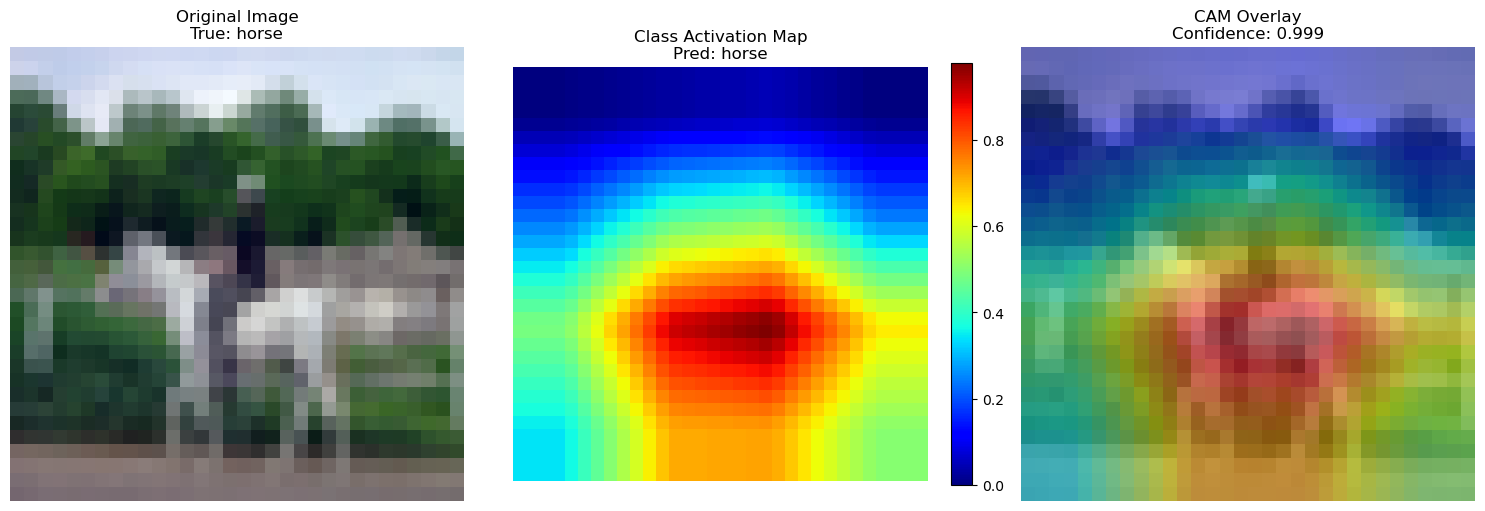


 CAM Statistics:
CAM shape: (32, 32)
CAM range: [0.0000, 0.9778]
CAM mean: 0.4299


In [18]:
import matplotlib.pyplot as plt
import numpy as np

CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                      'dog', 'frog', 'horse', 'ship', 'truck']

dataset = CIFAR10(root='./data', train=False, download=True, transform=transform_cifar10)
image_idx = np.random.randint(0, len(dataset))  # Immagine casuale
image, true_label = dataset[image_idx]
image = image.unsqueeze(0).to(device)
print(f"Testing on image {image_idx}, true class: {CIFAR10_CLASSES[true_label]}")


checkpoint = torch.load('model_CNN_very_deep.pth')


model = My_Configurable_CNN(
    input_size=(32, 32),
    input_channels=3, 
    hidden_channels=checkpoint['hidden_channels'],
    num_classes=10
).to(device)


model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


image = image.to(device)

# Forward pass to get logits and features
logits, features = model(image, return_cam=True)
predicted_class = logits.argmax(dim=1)
confidence = F.softmax(logits, dim=1)[0][predicted_class].item()
            
print(f"Predicted: {CIFAR10_CLASSES[predicted_class]} (confidence: {confidence:.3f})")
print(f"True label: {CIFAR10_CLASSES[true_label]}")

#
cam = model.get_cam(features, predicted_class)
cam = F.relu(cam)  # ReLU to keep only positive values
cam = cam - cam.min()
cam = cam / cam.max()

# Resize CAM to match input image size
cam_resized = F.interpolate(
            cam.unsqueeze(1), 
            size=image.shape[2:], 
            mode='bilinear', 
            align_corners=False
        )

cam_results(image, cam_resized, predicted_class, true_label, confidence, CIFAR10_CLASSES)


In [19]:
class CAM_ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(CAM_ResNet18, self).__init__()
        
        resnet = models.resnet18(pretrained=True)
        
        # Feature extractor 
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        
        # GAP and new classifier
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(512, num_classes)  # ResNet-18 has 512 feature
        
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)
    
    def forward(self, x, return_cam=False):
        features = self.features(x) 
        
        pooled = self.gap(features)
        pooled = pooled.view(pooled.size(0), -1)
        logits = self.classifier(pooled)
        
        if return_cam:
            return logits, features
        return logits
    
    def get_cam(self, features, class_idx):
        """Generate CAM for a specific class index."""
        weights = self.classifier.weight[class_idx].view(-1, 1, 1)
        cam = (weights * features).sum(dim=1)  # [batch, h, w]
        return cam

100%|██████████| 99.0M/99.0M [00:06<00:00, 16.2MB/s]


Extracting ./data/imagenette2-160.tgz to ./data
Testing on image 2433, true class: garbage truck


/home/eledaveri/miniconda3/envs/labs/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/eledaveri/miniconda3/envs/labs/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted: French horn (confidence: 0.636)
True label: garbage truck


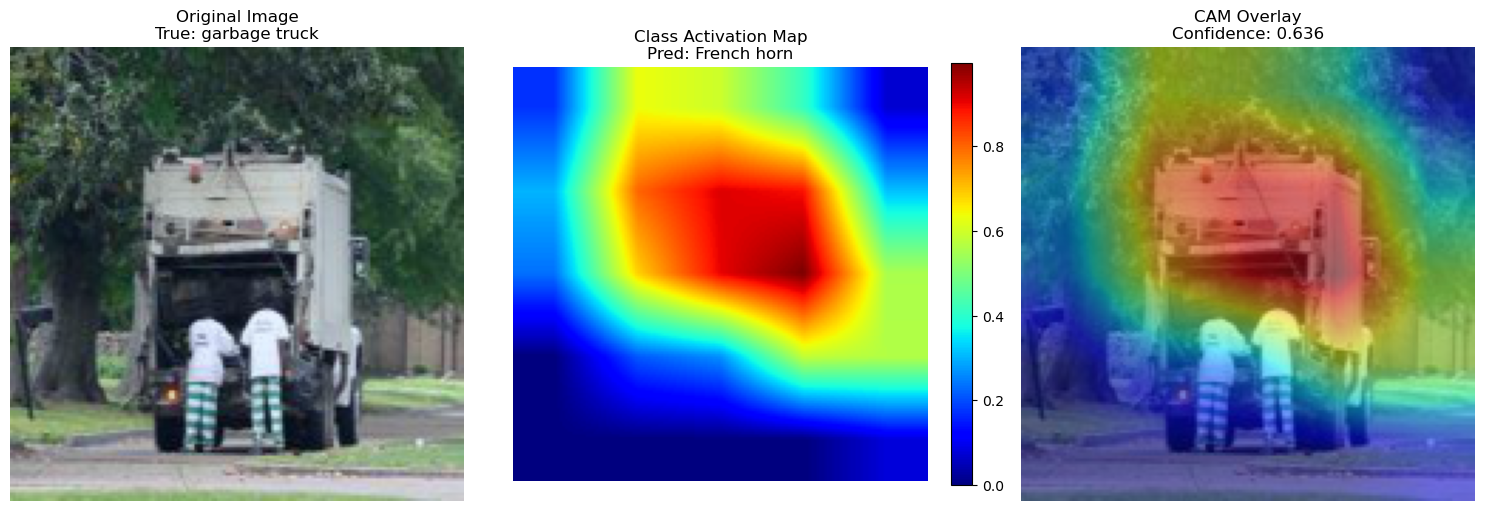


 CAM Statistics:
CAM shape: (160, 160)
CAM range: [0.0000, 0.9968]
CAM mean: 0.4078


In [21]:
transform_imagenette = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])

IMAGENETTE_CLASSES = [
        'tench', 'English springer', 'cassette player', 'chain saw', 'church',
        'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute'
    ]

dataset = Imagenette(root='./data', split='val', size='160px', 
                           download=True, transform=transform_imagenette)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

image_idx = np.random.randint(0, len(dataset))  # Random image
image, true_label = dataset[image_idx]
image = image.unsqueeze(0).to(device)
print(f"Testing on image {image_idx}, true class: {IMAGENETTE_CLASSES[true_label]}")

model = CAM_ResNet18(num_classes=len(IMAGENETTE_CLASSES)).to(device)
model.eval()
image = image.to(device)
# Forward pass to get logits and features
logits, features = model(image, return_cam=True)
predicted_class = logits.argmax(dim=1)
confidence = F.softmax(logits, dim=1)[0][predicted_class].item()
            
print(f"Predicted: {IMAGENETTE_CLASSES[predicted_class]} (confidence: {confidence:.3f})")
print(f"True label: {IMAGENETTE_CLASSES[true_label]}")

cam = model.get_cam(features, predicted_class)
cam = F.relu(cam)  # ReLU to keep only positive values
cam = cam - cam.min()
cam = cam / cam.max()

# Resize CAM to match input image size
cam_resized = F.interpolate(
            cam.unsqueeze(1), 
            size=image.shape[2:], 
            mode='bilinear', 
            align_corners=False
        )

cam_results(image, cam_resized, predicted_class, true_label, confidence,IMAGENETTE_CLASSES)